In [307]:
# pip install missingno
!pip install pyrsistent
!pip install match
!pip install scipy
!pip install -upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: pip install --upgrade pip

Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: -u


<h3>Import necessary Packages</h3>

In [308]:
import numpy as np
import pandas as pd
import seaborn as sns
from pandas_profiling import ProfileReport
import missingno as msno
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from scipy.stats import probplot, chi2_contingency, chi2, stats
%matplotlib inline

<h3> Import the csv file</h3>

In [304]:
from scipy.stats import probplot, chi2_contingency, chi2

In [3]:
cc_data_full_data= pd.read_csv("datasets/application_record.csv")
credit_status= pd.read_csv("datasets/credit_record.csv")

In [4]:
cc_data_full_data.head()


ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0   
2  5008806           M            Y               Y             0   
3  5008808           F            N               Y             0   
4  5008809           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0          427500.0               Working               Higher education   
1          427500.0               Working               Higher education   
2          112500.0               Working  Secondary / secondary special   
3          270000.0  Commercial associate  Secondary / secondary special   
4          270000.0  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0        Civil marriage   Rented apartment      -12005          -4542   
1        Civil marriage   Rented apartment      -12005          -4542   
2               Married  House / apartment      -21474          -1134   
3  Single / not married  House / apartment      -19110          -3051   
4  Single / not married  House / apartment      -19110          -3051   

   FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
0           1                1           0           0             NaN   
1           1                1           0           0             NaN   
2           1                0           0           0  Security staff   
3           1                0           1           1     Sales staff   
4           1                0           1           1     Sales staff   

   CNT_FAM_MEMBERS  
0              2.0  
1              2.0  
2              2.0  
3              1.0  
4              1.0

<h3>Creating the target variable</h3>

In [134]:
begin_month=pd.DataFrame(credit_status.groupby(['ID'])['MONTHS_BALANCE'].agg(min))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'Account age'})
cc_data_full_data=pd.merge(cc_data_full_data,begin_month,how='left',on='ID')

In [135]:
credit_status['dep_value'] = None
credit_status['dep_value'][credit_status['STATUS'] =='2']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='3']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='4']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='5']='Yes'

In [136]:
cpunt=credit_status.groupby('ID').count()
cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes'
cpunt['dep_value'][cpunt['dep_value'] == 0]='No'
cpunt = cpunt[['dep_value']]
cc_data_full_data = pd.merge(cc_data_full_data,cpunt,how='inner',on='ID')
cc_data_full_data['Is high risk']=cc_data_full_data['dep_value']
cc_data_full_data.loc[cc_data_full_data['Is high risk']=='Yes','Is high risk']=1
cc_data_full_data.loc[cc_data_full_data['Is high risk']=='No','Is high risk']=0
cc_data_full_data.drop('dep_value',axis=1,inplace=True)
pd.options.mode.chained_assignment = None # hide warning Se

In [137]:
# cc_data_full_data.drop(['Account age_x','Account age_y'], axis=1, inplace=True)
cc_data_full_data.head()

ID Gender Has a car Has a property  Children count    Income  \
0  5008804      M         Y              Y               0  427500.0   
1  5008805      M         Y              Y               0  427500.0   
2  5008806      M         Y              Y               0  112500.0   
3  5008808      F         N              Y               0  270000.0   
4  5008809      F         N              Y               0  270000.0   

      Employment status                Education level        Marital status  \
0               Working               Higher education        Civil marriage   
1               Working               Higher education        Civil marriage   
2               Working  Secondary / secondary special               Married   
3  Commercial associate  Secondary / secondary special  Single / not married   
4  Commercial associate  Secondary / secondary special  Single / not married   

            Dwelling    Age  Employment length  Has a mobile phone  \
0   Rented apartment -12005              -4542                   1   
1   Rented apartment -12005              -4542                   1   
2  House / apartment -21474              -1134                   1   
3  House / apartment -19110              -3051                   1   
4  House / apartment -19110              -3051                   1   

   Has a work phone  Has a phone  Has an email       Job title  \
0                 1            0             0             NaN   
1                 1            0             0             NaN   
2                 0            0             0  Security staff   
3                 0            1             1     Sales staff   
4                 0            1             1     Sales staff   

   Family member count Is high risk  Account age  
0                  2.0            0          -15  
1                  2.0            0          -14  
2                  2.0            0          -29  
3                  1.0            0           -4  
4                  1.0            0          -26

In [138]:
cc_data_full_data['Is high risk'].value_counts()

0    35841
1      616
Name: Is high risk, dtype: int64

<h2> Rename features</h2>

In [139]:
cc_data_full_data= cc_data_full_data.rename(columns= {
    'CODE_GENDER': 'Gender',
    'FLAG_OWN_CAR':'Has a car',
    'FLAG_OWN_REALTY': 'Has a property',
    'CNT_CHILDREN':'Children count',
    'AMT_INCOME_TOTAL':'Income',
    'NAME_INCOME_TYPE':'Employment status',
    'NAME_EDUCATION_TYPE':'Education level',
    'NAME_FAMILY_STATUS':'Marital status',
    'NAME_HOUSING_TYPE':'Dwelling',
    'DAYS_BIRTH': 'Age',
    'DAYS_EMPLOYED':'Employment length',
    'FLAG_MOBIL': 'Has a mobile phone',
    'FLAG_WORK_PHONE': 'Has a work phone',
    'FLAG_PHONE': 'Has a phone',
    'FLAG_EMAIL': 'Has an email',
    'OCCUPATION_TYPE': 'Job title',
    'CNT_FAM_MEMBERS': 'Family member count',
    'Account age': 'Account age'
    
})

In [140]:
cc_data_full_data.head()

ID Gender Has a car Has a property  Children count    Income  \
0  5008804      M         Y              Y               0  427500.0   
1  5008805      M         Y              Y               0  427500.0   
2  5008806      M         Y              Y               0  112500.0   
3  5008808      F         N              Y               0  270000.0   
4  5008809      F         N              Y               0  270000.0   

      Employment status                Education level        Marital status  \
0               Working               Higher education        Civil marriage   
1               Working               Higher education        Civil marriage   
2               Working  Secondary / secondary special               Married   
3  Commercial associate  Secondary / secondary special  Single / not married   
4  Commercial associate  Secondary / secondary special  Single / not married   

            Dwelling    Age  Employment length  Has a mobile phone  \
0   Rented apartment -12005              -4542                   1   
1   Rented apartment -12005              -4542                   1   
2  House / apartment -21474              -1134                   1   
3  House / apartment -19110              -3051                   1   
4  House / apartment -19110              -3051                   1   

   Has a work phone  Has a phone  Has an email       Job title  \
0                 1            0             0             NaN   
1                 1            0             0             NaN   
2                 0            0             0  Security staff   
3                 0            1             1     Sales staff   
4                 0            1             1     Sales staff   

   Family member count Is high risk  Account age  
0                  2.0            0          -15  
1                  2.0            0          -14  
2                  2.0            0          -29  
3                  1.0            0           -4  
4                  1.0            0          -26

<h3>Split the data into training and test sets, creating a copy of the datasets</h3>

In [141]:
def data_split(df, test_size):
    train_df, test_df= train_test_split(df, test_size= test_size, random_state= 42)
    return train_df.reset_index(drop= True), test_df.reset_index(drop= True)

In [142]:
cc_train_original, cc_test_original= data_split(cc_data_full_data, 0.2)

In [143]:
cc_train_original.to_csv('datasets/train.csv', index= False)

In [144]:
cc_test_original.to_csv('datasets/test.csv', index= False)

In [145]:
cc_train_copy= cc_train_original.copy()

In [146]:
cc_test_copy= cc_test_original.copy()

<h1> Explore the Data</h1>

<h3>Pandas Profiling</h3>

In [147]:
profile_report= ProfileReport(cc_train_copy, explorative= True, dark_mode= True)
profile_report_file_path= Path('pandas_profile_file/credit_pred_profile.html')
try:
    profile_report_file_path.resolve(strict= True)
except FileNotFoundError:
    profile_report.to_file("pandas_profile_file/credit_pred_profile.html")

<h1>New data</h1>

In [148]:
cc_data_full_data.head()


ID Gender Has a car Has a property  Children count    Income  \
0  5008804      M         Y              Y               0  427500.0   
1  5008805      M         Y              Y               0  427500.0   
2  5008806      M         Y              Y               0  112500.0   
3  5008808      F         N              Y               0  270000.0   
4  5008809      F         N              Y               0  270000.0   

      Employment status                Education level        Marital status  \
0               Working               Higher education        Civil marriage   
1               Working               Higher education        Civil marriage   
2               Working  Secondary / secondary special               Married   
3  Commercial associate  Secondary / secondary special  Single / not married   
4  Commercial associate  Secondary / secondary special  Single / not married   

            Dwelling    Age  Employment length  Has a mobile phone  \
0   Rented apartment -12005              -4542                   1   
1   Rented apartment -12005              -4542                   1   
2  House / apartment -21474              -1134                   1   
3  House / apartment -19110              -3051                   1   
4  House / apartment -19110              -3051                   1   

   Has a work phone  Has a phone  Has an email       Job title  \
0                 1            0             0             NaN   
1                 1            0             0             NaN   
2                 0            0             0  Security staff   
3                 0            1             1     Sales staff   
4                 0            1             1     Sales staff   

   Family member count Is high risk  Account age  
0                  2.0            0          -15  
1                  2.0            0          -14  
2                  2.0            0          -29  
3                  1.0            0           -4  
4                  1.0            0          -26

In [149]:
cc_data_full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   Gender               36457 non-null  object 
 2   Has a car            36457 non-null  object 
 3   Has a property       36457 non-null  object 
 4   Children count       36457 non-null  int64  
 5   Income               36457 non-null  float64
 6   Employment status    36457 non-null  object 
 7   Education level      36457 non-null  object 
 8   Marital status       36457 non-null  object 
 9   Dwelling             36457 non-null  object 
 10  Age                  36457 non-null  int64  
 11  Employment length    36457 non-null  int64  
 12  Has a mobile phone   36457 non-null  int64  
 13  Has a work phone     36457 non-null  int64  
 14  Has a phone          36457 non-null  int64  
 15  Has an email         36457 non-null 

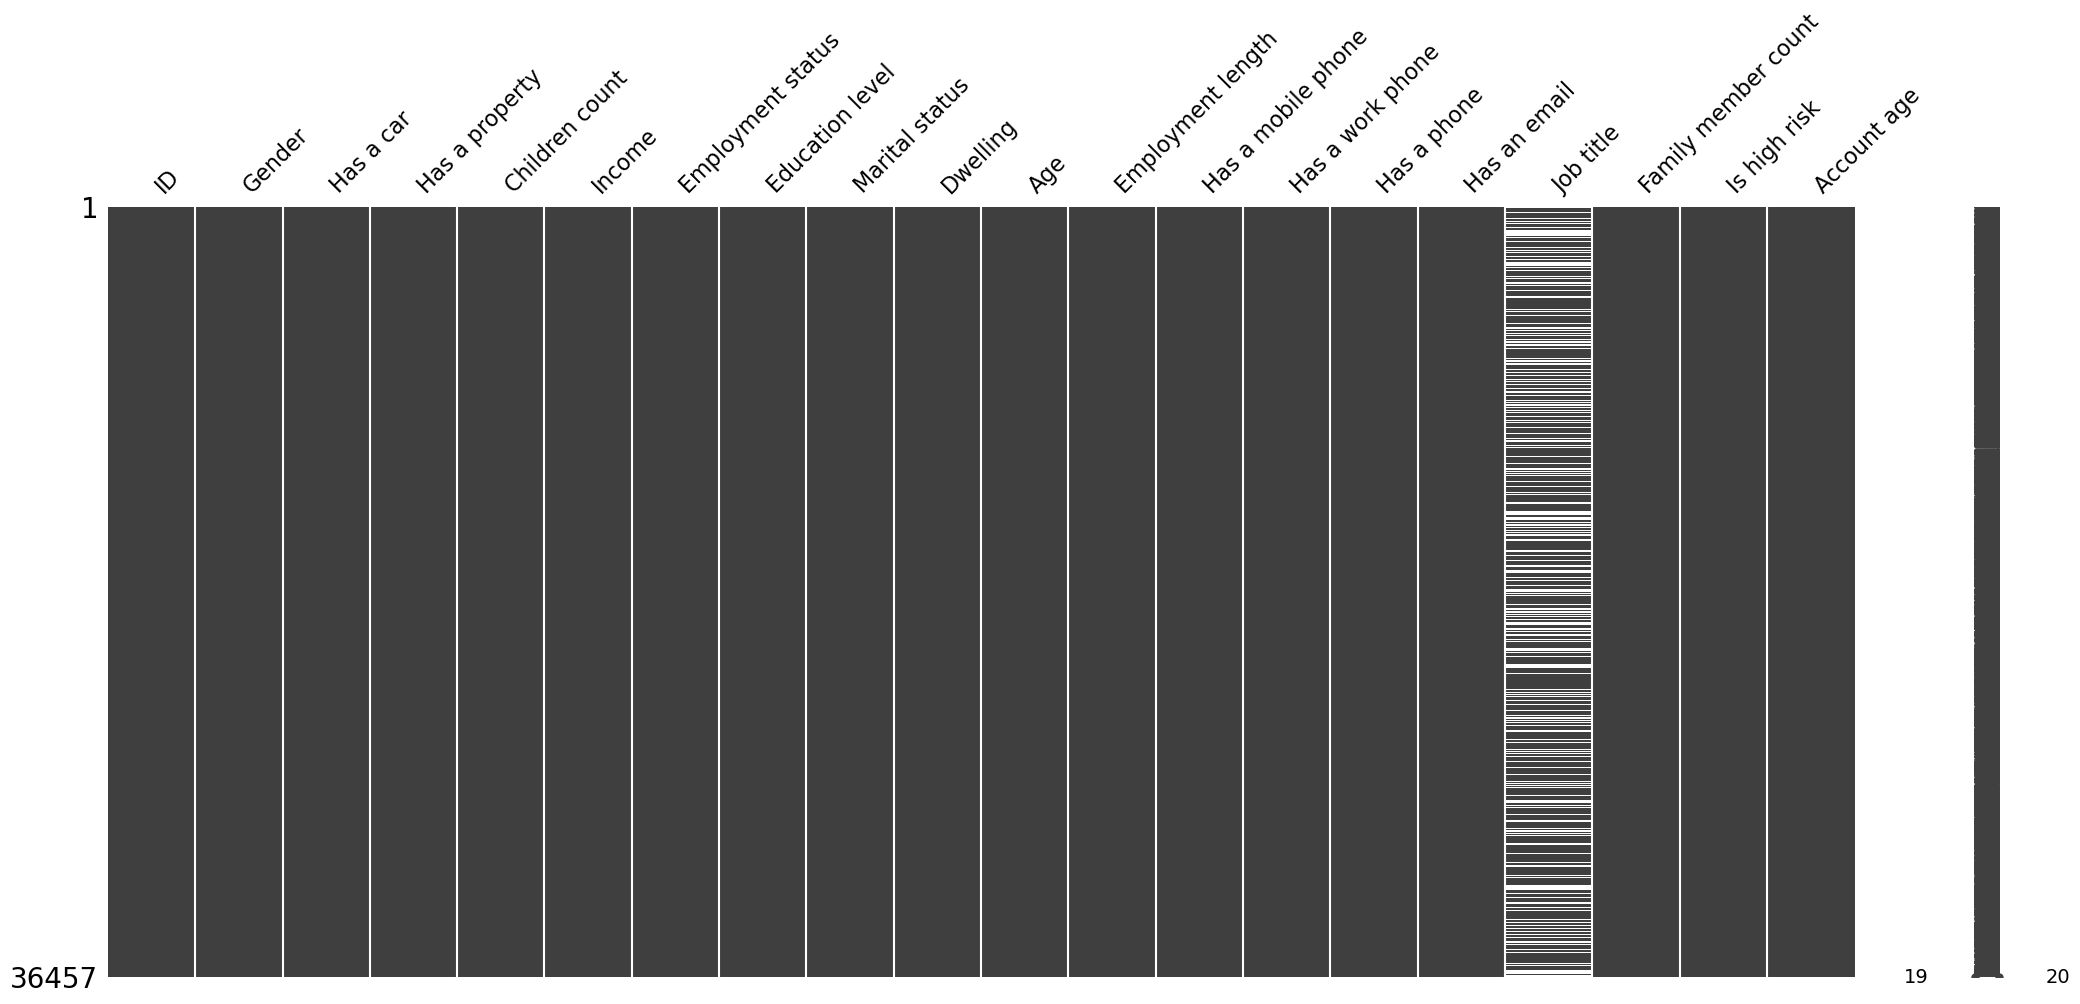

In [150]:
msno.matrix(cc_data_full_data)
plt.show()

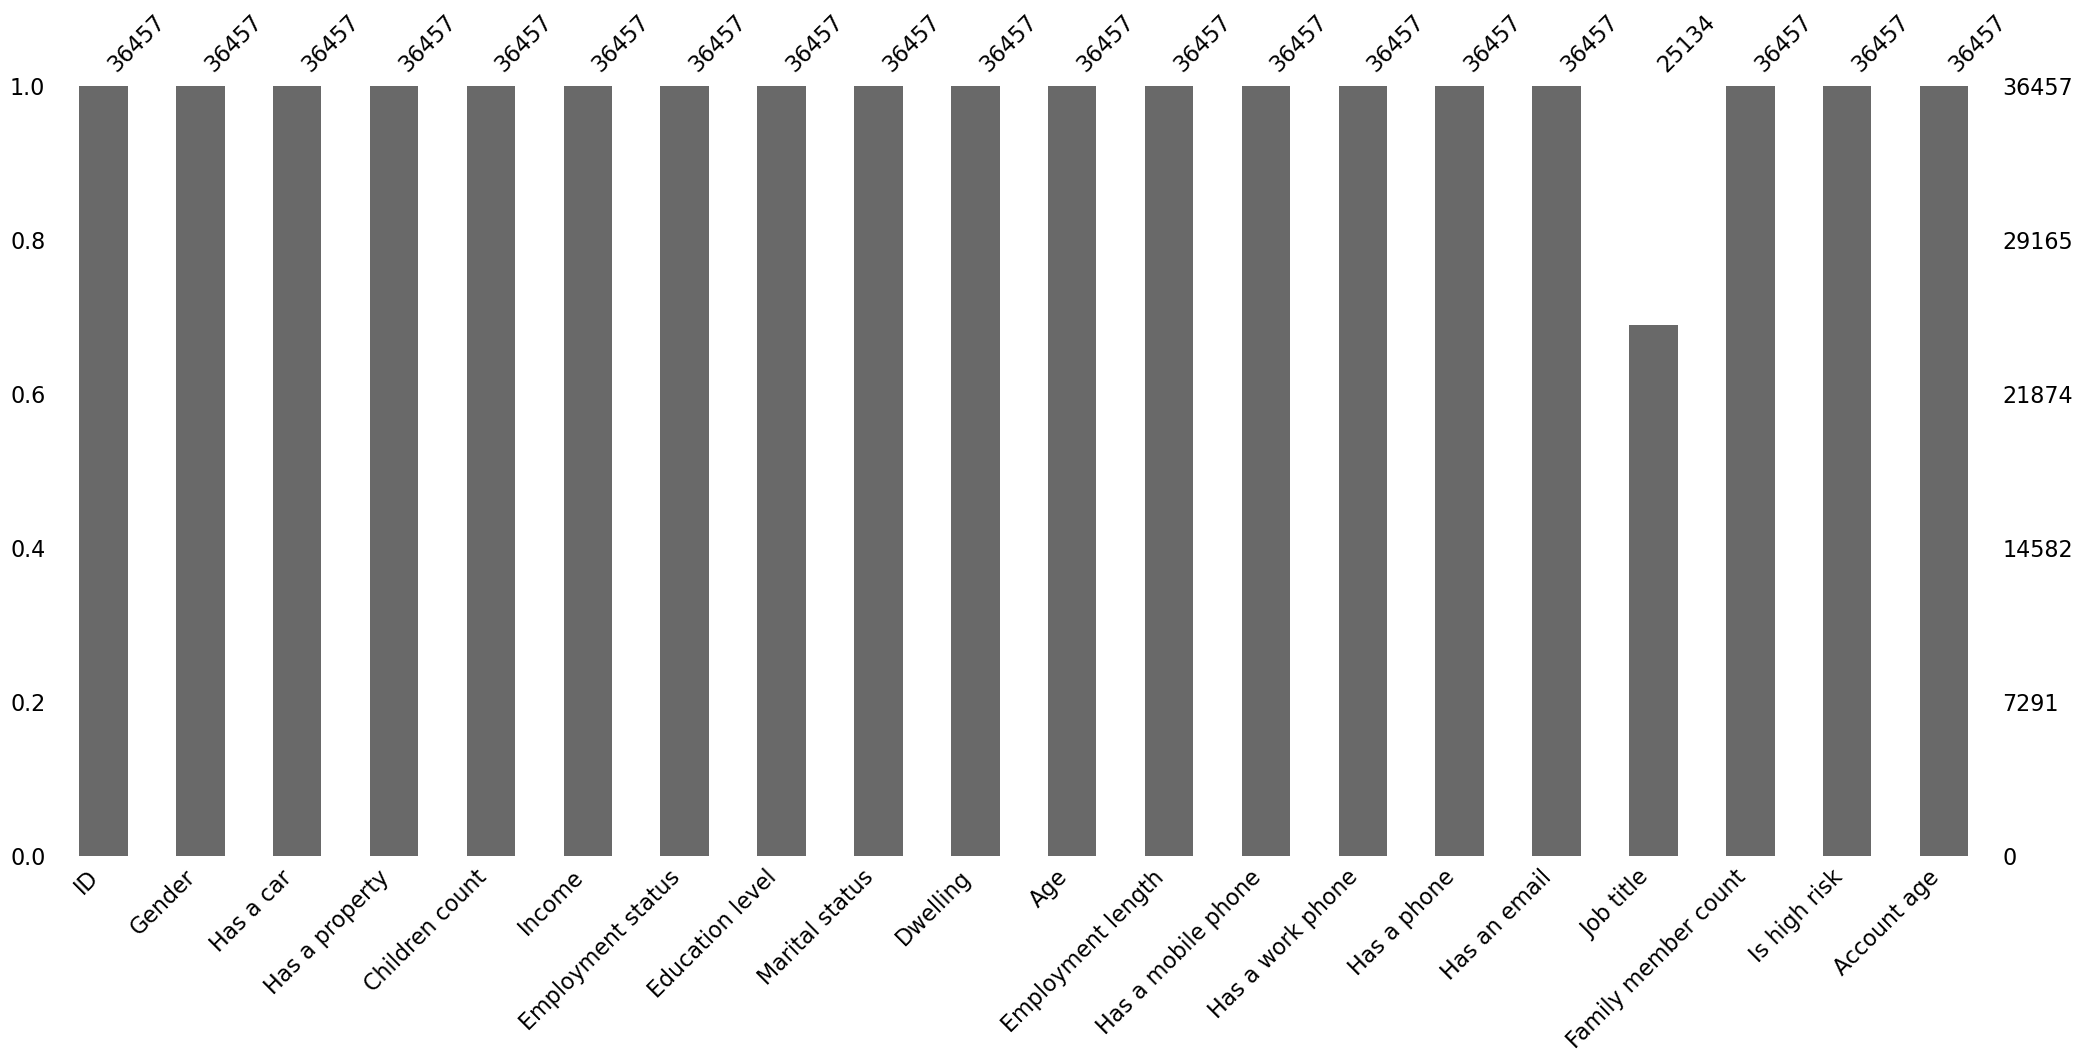

In [151]:
msno.bar(cc_data_full_data)
plt.show()

<h3>Functions used to explore each feature</h3>

In [152]:
def value_cnt_norm_cal(df, feature):
    ftr_value_cnt= df[feature].value_counts()
    ftr_value_cnt_norm= df[feature].value_counts(normalize= True)*100
    ftr_value_cnt_concat= pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis= 1)
    ftr_value_cnt_concat.columns= ['Count', 'Frequency(%)']
    return ftr_value_cnt_concat

In [153]:
def get_info_feat(df,feature):
    if feature == 'Age':
        #change the feature to be express in positive numbers days
        print('Description:\n{}'.format((np.abs(df[feature])/365.25).describe()))
        print('*'*50)
        print('Object type:{}'.format(df[feature].dtype))
    elif feature == 'Employment length':
        #select only the rows where the rows are negative to ifnore those who have retired or unemployed
        employment_len_no_ret = cc_train_copy['Employment length'][cc_train_copy['Employment length'] < 0]
        employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
        print('Description:\n{}'.format((employment_len_no_ret_yrs).describe()))
        print('*'*50)
        print('Object type:{}'.format(employment_len_no_ret.dtype))
    elif feature == 'Account age':
        #change the account age to a positive number of months
        print('Description:\n{}'.format((np.abs(df[feature])).describe()))
        print('_'*50)
        print('Object type:{}'.format(df[feature].dtype))
    else:
              print('Description:\n{}'.format(df[feature].describe()))
              print('_'*50)
              print('Object type:\n{}'.format(df[feature].dtype))
              print('_'*50)
              value_cnt = value_cnt_norm_cal(df,feature)
              print('Value count:\n{}'.format(value_cnt))

                

<h1> Pie Plot</h1>

In [154]:
def create_pie_plot(df, feature):
    if feature == 'Dwelling' or feature =="Education level":
        ratio_size = value_cnt_norm_cal(df, feature)
        ratio_size_len = len(ratio_size.index)
        ratio_list = []
        for i in range(ratio_size_len):
            ratio_list.append(ratio_size.iloc[i]['Frequency(%)'])
        fig, ax = plt.subplots(figsize=(8,8))
        # ratio_size= value_cnt_norm_cal(df, feature)
        # ratio_size_len= len(ratio_size.index)
        # ratio_list= []
        # for i in range (ratio_size_len):
        #     ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
        # fig, ax= plt.subplots(figsize= (8,8))
        # #1.2f%% display decimals in the pie chart with 2 decimal in places
        plt.pie(ratio_list, startangle= 90, wedgeprops= {'edgecolor':'black'})
        plt.title('Pie chart of {}'.format(feature))
        plt.legend(loc= 'best', labels= ratio_size.index)
        plt.axis('equal')
        return plt.show()
    else:
        ratio_size= value_cnt_norm_cal(df, feature)
        ratio_size_len= len(ratio_size.index)
        ratio_list=[]
        for i in range(ratio_size_len):
            ratio_list.append(ratio_size.iloc[i]['Frequency(%)'])
        fig, ax= plt.subplots(figsize= (8,8))
        plt.pie(ratio_list, labels= ratio_size.index, autopct= '%1.2f%%', startangle= 90, wedgeprops= {'edgecolor':'black'})
        plt.legend(loc= 'best')
        plt.axis('equal')
        return plt.show()
        

<h1> Bar plot</h1>

In [155]:
#create bar plot
def create_bar_plot(df, feature):
    if feature == "Marital status" or feature == "Dwelling" or feature == "Job title" or feature == "Employment status" or feature == "Education level":
        fig, ax = plt.subplots(figsize= (6,10))
        sns.barplot(x= value_cnt_norm_cal(df,feature). index, y= value_cnt_norm_cal(df, feature).values[:,0])
        ax.set_xticklabels(labels= value_cnt_norm_cal(df, feature).index, rotation= 45, ha= "right")
        plt.xlabel('{}' .format(feature))
        plt.ylabel('Count')
        plt.title('{} count'.format(feature))
        return plt.show
    else:
        fig, ax= plt.subplots(figsize= (6,10))
        sns.barplot(x= value_cnt_norm_cal(df, feature).index, y= value_cnt_norm_cal(df, feature).values[:,0])
        plt.ylabel('count')
        plt.xlabel('{}'.format(feature))
        plt.title('{} count'.format(feature))
        return plt.show()
        
        

<h1>Box plot</h1>

In [156]:
def create_box_plot(df,feature):
    if feature == 'Age':
        fig, ax = plt.subplots(figsize=(2,8))
        # change the feature to be express in positive numbers days
        sns.boxplot(y=np.abs(df[feature])/365.25)
        plt.title('{} distribution(Boxplot)'.format(feature))
        return plt.show()
    elif feature==  'Children count':
        fig, ax = plt.subplots(figsize=(2,8))
        sns.boxplot(y=df[feature])
        plt.title('{} distribution(Boxplot)'.format(feature))
        plt.yticks(np.arange(0,df[feature].max(),1))
        return plt.show()
    elif feature == 'Employment length':
        fig, ax = plt.subplots(figsize=(2,8))
        employment_len_no_ret = cc_train_copy['Employment length'][cc_train_copy['Employment length'] < 0]
        # employement length in days is a negative number so we need to change it to positive and change it to days
        employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
        sns.boxplot(y=employment_len_no_ret_yrs)
        plt.title('{} distribution(Boxplot)'.format(feature))
        plt.yticks(np.arange(0,employment_len_no_ret_yrs.max(),2))
        return plt.show()
    elif feature ==  'Income':
        fig, ax = plt.subplots(figsize=(2,8))
        sns.boxplot(y=df[feature])
        plt.title('{} distribution(Boxplot)'.format(feature))
        # suppress scientific notation
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        return plt.show()
    elif feature== 'Account age':
        fig, ax = plt.subplots(figsize=(2,8))
        sns.boxplot(y=np.abs(df[feature]))
        plt.title('{} distribution(Boxplot)'.format(feature))
        return plt.show()
    else:
        fig, ax = plt.subplots(figsize=(2,8))
        sns.boxplot(y=df[feature])
        plt.title('{} distribution(Boxplot)'.format(feature))
        return plt.show()

<h1>Hist plot</h1>

In [157]:
def create_hist_plot(df, feature, the_bins= 50):
    fig, ax= plt.subplots(figsize= (18,10))
    if feature == 'Age':
        sns.histplot(np.abs(df[feature])/365.25, bins= the_bins, kde= True)
    elif feature =="Income":
        sns.histplot(df[feature], bins= the_bins, kde = True)
        ax.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    elif feature == 'Employment length':
        employment_len_no_ret= cc_train_copy['Employment length'][cc_train_copy['Employment length']<0]
        employment_len_no_ret_yrs= np.abs(employment_len_no_ret)/365.25
        sns.histplot(employment_len_no_ret_yrs, bins= the_bins, kde= True)
    elif feature == "Account age":
        sns.histplot(np.abs(df[feature]), bins= the_bins, kde= True)
    else:
        sns.histplot(df[feature], bins= the_bins, kde= True)
    plt.title('{} distribution'.format(feature))
    return plt.show()

<h1>Low High Risk Box Plot</h1>

In [158]:
# def low_high_risk_box_plot(df, feature):
#     mean= df.groupby('Is high risk')[feature].mean()
#     fig, ax= plt.subplots(figsize=(5,8))
#     sns.boxplot(y= df[feature], x= df['Is high risk'])
#     plt.xticks(ticks= [0,1], labels= ['no', 'yes'])
    
#     if feature == 'Age':
#         print(np.abs(mean))
#         sns.boxplot(y= np.abs(df[feature])/365.25,
#                     x= df['Is high risk'])
#     elif feature == 'Income':
#         print(np.abs(mean))
#         sns.boxplot(y= np.abs(df[feature]),
#                    x= df['Is high risk'])
#         ax.get_yaxis().set_major_formatter(
#         matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), " , ")))
#     elif feature == "Employment length":
        
#         # checking the age of hifh risk individuals with the age of low risk individuals (those who are employed)
#         employment_no_ret= cc_train_copy['Employment length'][cc_train_copy['Employment length']<0]
#         employment_no_ret_idx= employment_no_ret.index
#         employment_len_no_ret_yrs= np.abs(employment_no_ret)/365.25
#         employment_len_no_ret_df= cc_train_copy.iloc[employment_no_ret_idx][['Employment length', 'Is high risk']]
#         employment_no_ret_is_high_risk= employment_len_no_ret_df.groupby('Is high risk')['Employment length'].mean()
#         print(np.abs(employment_no_ret_is_high_risk)/365.25)
#         # compare the age of high risk individuals with the age of low risk individuals (those who are employed)
#         # print(np.abs(employment_no_ret_is_high_risk)/365.25)
#         sns.boxplot(y= employment_len_no_ret_yrs, x= df['Is high risk'])
#     else:
#         print(np.abs(mean))
#         sns.boxplot(y= np.abs(df[feature]), x= df['Is high risk'])
#     plt.title('High risk individuals grouped by {}'. format(feature))
#     return plt.show()

<h1> Low high Risk Bar Plot</h1>

In [159]:
print(np.abs(cc_train_copy.groupby('Is high risk')['Age'].mean()/365.25))

Is high risk
0    43.753103
1    43.538148
Name: Age, dtype: float64


In [160]:
# High risk vs low risk applicants compared on a box plot
def low_high_risk_box_plot(df,feature):
    if feature== 'Age':
            print(np.abs(df.groupby('Is high risk')[feature].mean()/365.25))
            fig, ax = plt.subplots(figsize=(5,8))
            sns.boxplot(y=np.abs(df[feature])/365.25,x=df['Is high risk'])
            plt.xticks(ticks=[0,1],labels=['no','yes'])
            plt.title('High risk individuals grouped by age')
            return plt.show()
    elif feature =='Income':
        print(np.abs(df.groupby('Is high risk')[feature].mean()))
        fig, ax = plt.subplots(figsize=(5,8))
        sns.boxplot(y=np.abs(df[feature]),x=df['Is high risk'])
        plt.xticks(ticks=[0,1],labels=['no','yes'])
        # suppress scientific notation
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        plt.title('High risk individuals grouped by {}'.format(feature))
        return plt.show()
    elif feature== 'Employment length':
        #checking is an applicant is high risk or not (for those who have negative employment length aka the employed ones)
        employment_no_ret = cc_train_copy['Employment length'][cc_train_copy['Employment length'] <0]
        employment_no_ret_idx = employment_no_ret.index
        employment_len_no_ret_yrs = np.abs(employment_no_ret)/365.25
        employment_no_ret_df = cc_train_copy.iloc[employment_no_ret_idx][['Employment length','Is high risk']]
        employment_no_ret_is_high_risk = employment_no_ret_df.groupby('Is high risk')['Employment length'].mean()
        # compare the age of high risk individuals with the age of low risk individuals (those who are employed)
        print(np.abs(employment_no_ret_is_high_risk)/365.25)
        fig, ax = plt.subplots(figsize=(5,8))
        sns.boxplot(y=employment_len_no_ret_yrs,x=df['Is high risk'])
        plt.xticks(ticks=[0,1],labels=['no','yes'])
        plt.title('High vs low risk individuals grouped by {}'.format(feature))
        return plt.show()
    else:
        print(np.abs(df.groupby('Is high risk')[feature].mean()))
        fig, ax = plt.subplots(figsize=(5,8))
        sns.boxplot(y=np.abs(df[feature]),x=df['Is high risk'])
        plt.xticks(ticks=[0,1],labels=['no','yes'])
        plt.title('High risk individuals grouped by {}'.format(feature))
        return plt.show()
   

<h1>Low high Risk Bar Plot
</h1>

In [161]:
def low_high_risk_bar_plot(df,feature):
    is_high_risk_grp = df.groupby(feature)['Is high risk'].sum()
    is_high_risk_grp_srt = is_high_risk_grp.sort_values(ascending=False)
    # print(dict(is_high_risk_grp_srt))
    mean_val= df['Is high risk'].mean()
    median_val= df['Is high risk'].median()
    
    fig, ax = plt.subplots(figsize=(6,10))
    sns.barplot(x=is_high_risk_grp_srt.index,y=is_high_risk_grp_srt.values)
    ax.set_xticklabels(labels=is_high_risk_grp_srt.index,rotation=45, ha='right')
    
    ax.axhline(y= mean_val, color= 'red', label= 'mean')
    plt.ylabel('Count')
    plt.title('High risk applicants count grouped by {}'.format(feature))
    return plt.show()


<h1>Univariate Analysis</h1>

<h1>Gender</h1>

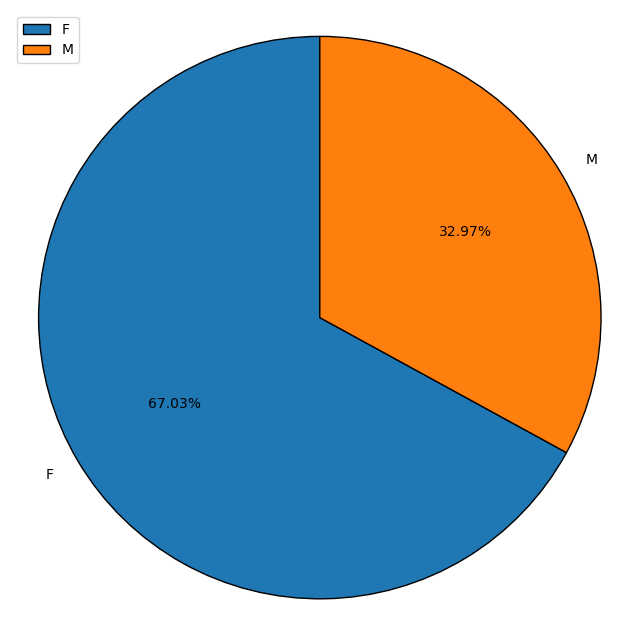

In [162]:
create_pie_plot(cc_train_copy, 'Gender')

Interpretation:
Majority of the applicants are Female

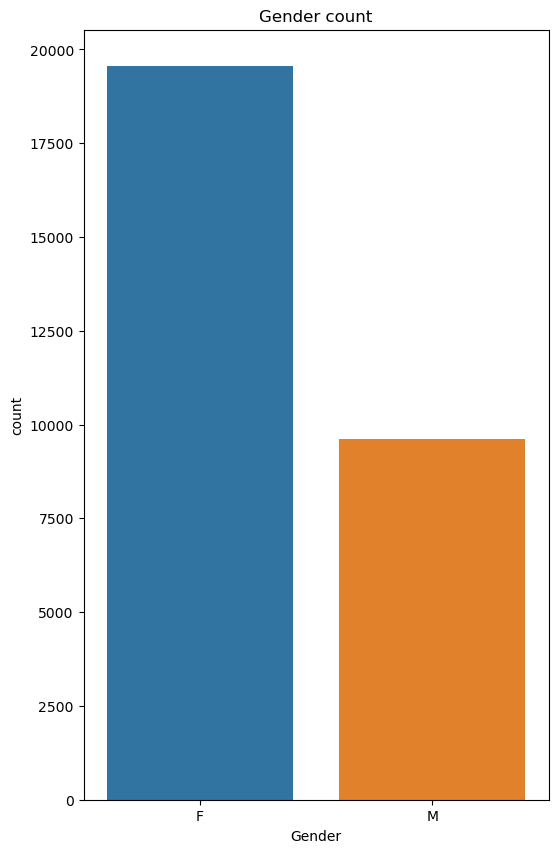

In [163]:
create_bar_plot(cc_train_copy, 'Gender')

<h1> Age</h1>

In [164]:
get_info_feat(cc_train_copy, 'Age')

Description:
count    29165.000000
mean        43.749425
std         11.507180
min         21.095140
25%         34.154689
50%         42.614648
75%         53.234771
max         68.862423
Name: Age, dtype: float64
**************************************************
Object type:int64


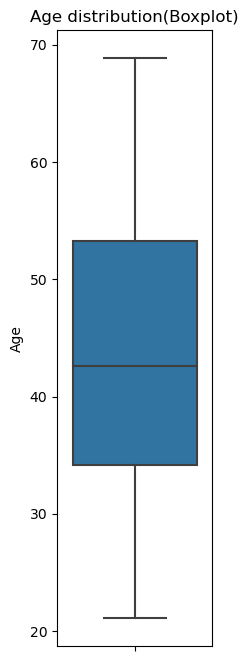

In [165]:
create_box_plot(cc_train_copy, 'Age')

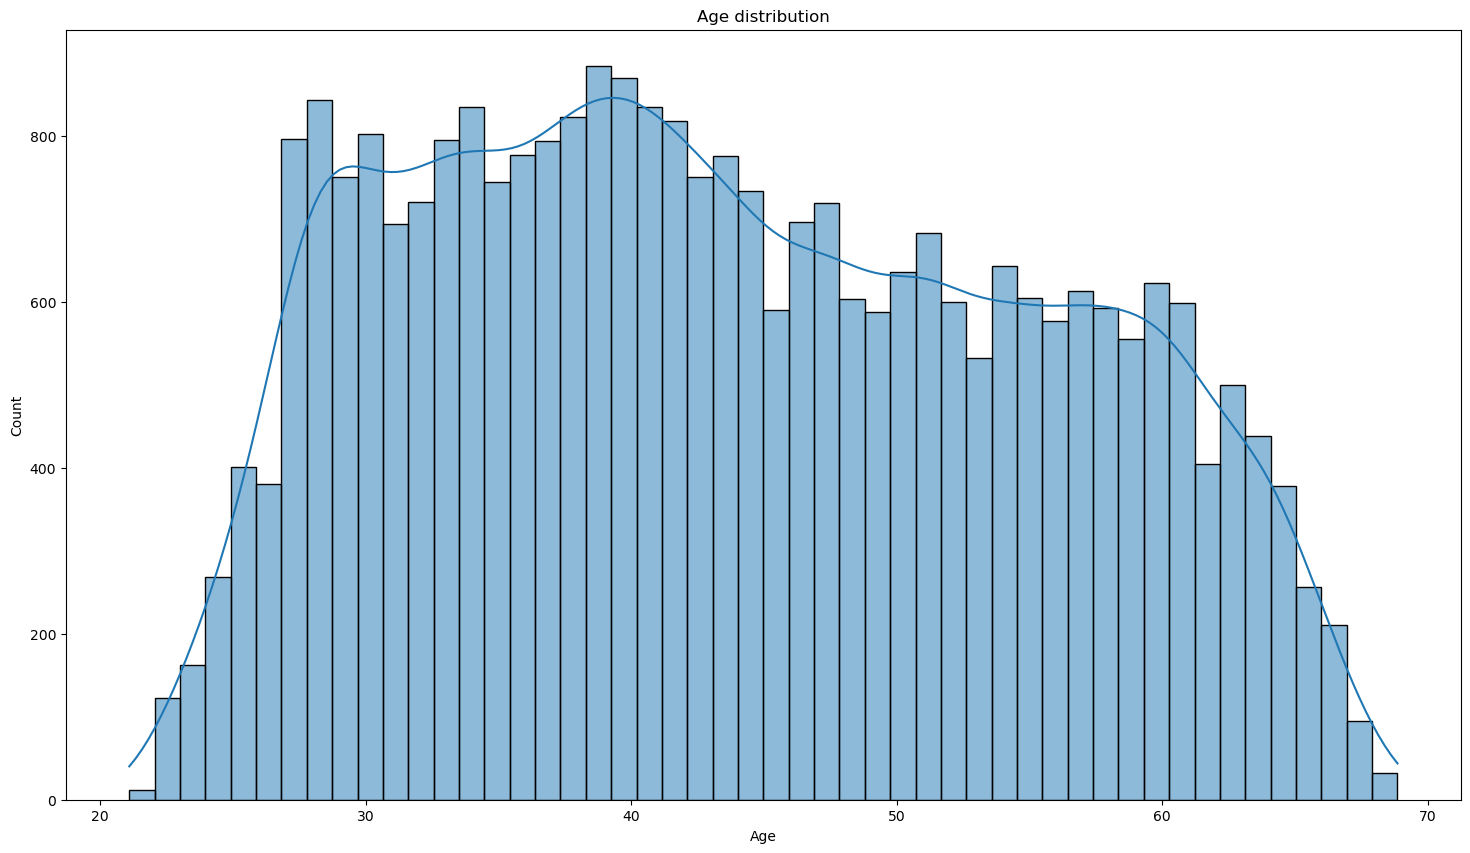

In [166]:
create_hist_plot(cc_train_copy, 'Age')

Is high risk
0    43.753103
1    43.538148
Name: Age, dtype: float64


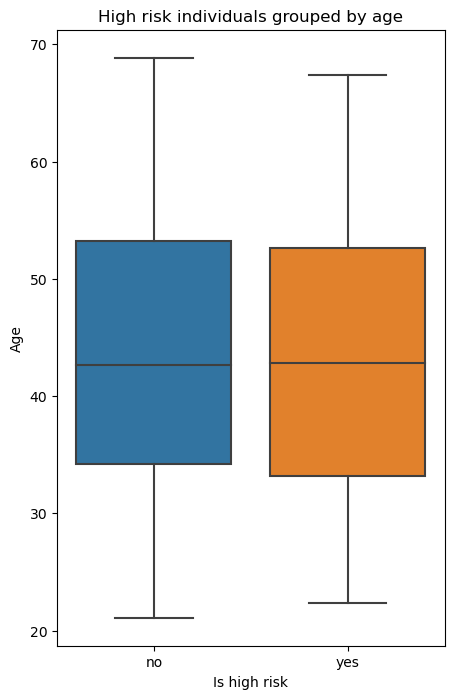

In [167]:
low_high_risk_box_plot(cc_train_copy, 'Age')

<h1>Marital Status</h1>


In [168]:
get_info_feat(cc_train_copy, 'Marital status')

Description:
count       29165
unique          5
top       Married
freq        20044
Name: Marital status, dtype: object
__________________________________________________
Object type:
object
__________________________________________________
Value count:
                      Count  Frequency(%)
Married               20044     68.726213
Single / not married   3864     13.248757
Civil marriage         2312      7.927310
Separated              1712      5.870050
Widow                  1233      4.227670


<function matplotlib.pyplot.show(close=None, block=None)>

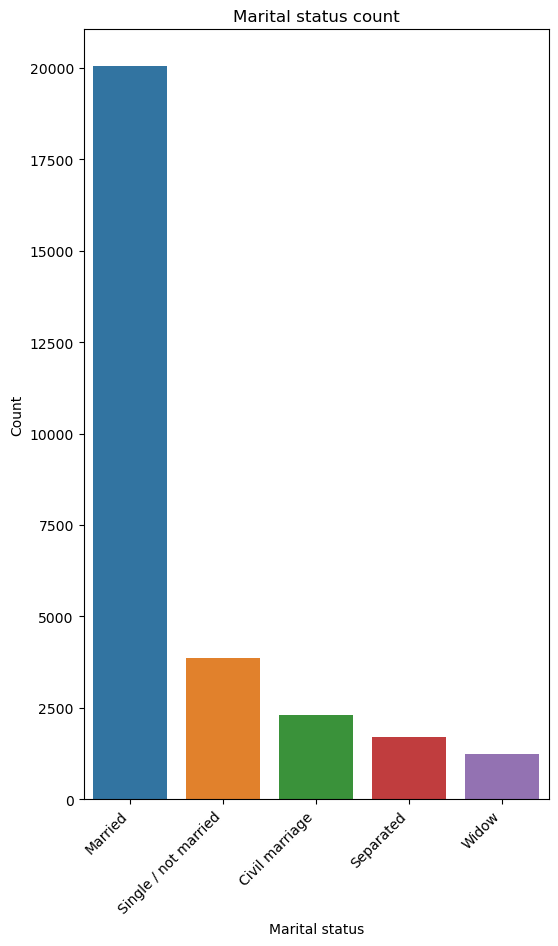

In [169]:
create_bar_plot(cc_train_copy, 'Marital status')

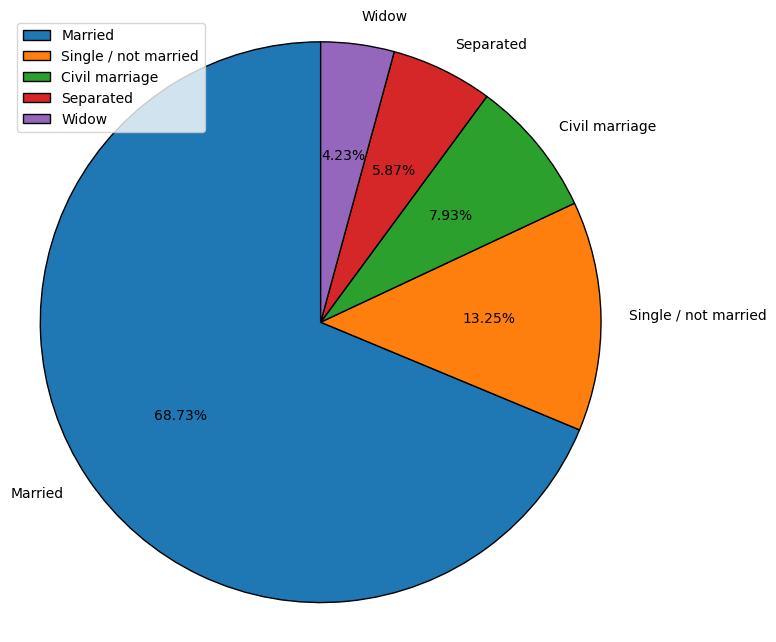

In [170]:
create_pie_plot(cc_train_copy, 'Marital status')

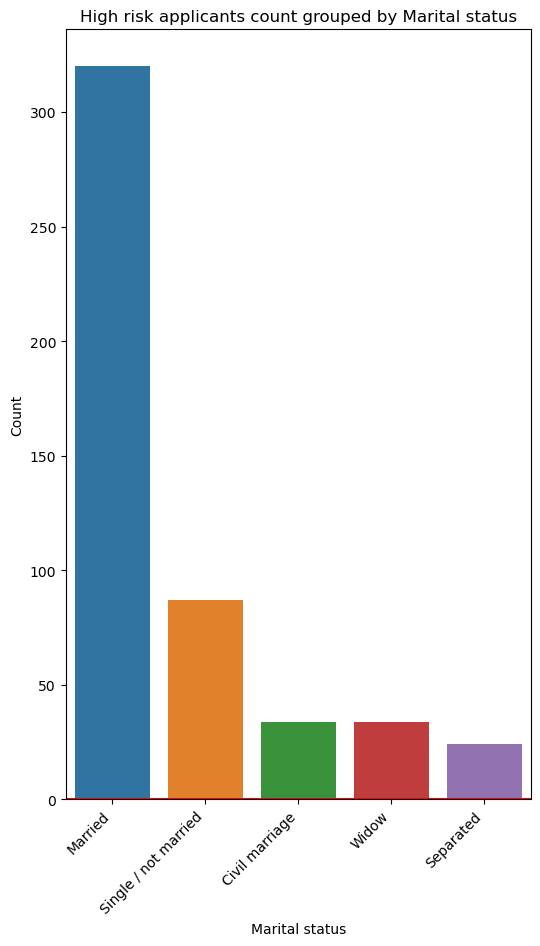

In [171]:
low_high_risk_bar_plot(cc_train_copy, 'Marital status')

<h1>Family member count</h1>

In [172]:
get_info_feat(cc_train_copy,"Family member count")

Description:
count    29165.000000
mean         2.197531
std          0.912189
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         20.000000
Name: Family member count, dtype: float64
__________________________________________________
Object type:
float64
__________________________________________________
Value count:
      Count  Frequency(%)
2.0   15552     53.324190
1.0    5613     19.245671
3.0    5121     17.558718
4.0    2503      8.582205
5.0     309      1.059489
6.0      48      0.164581
7.0      14      0.048003
9.0       2      0.006858
15.0      2      0.006858
20.0      1      0.003429


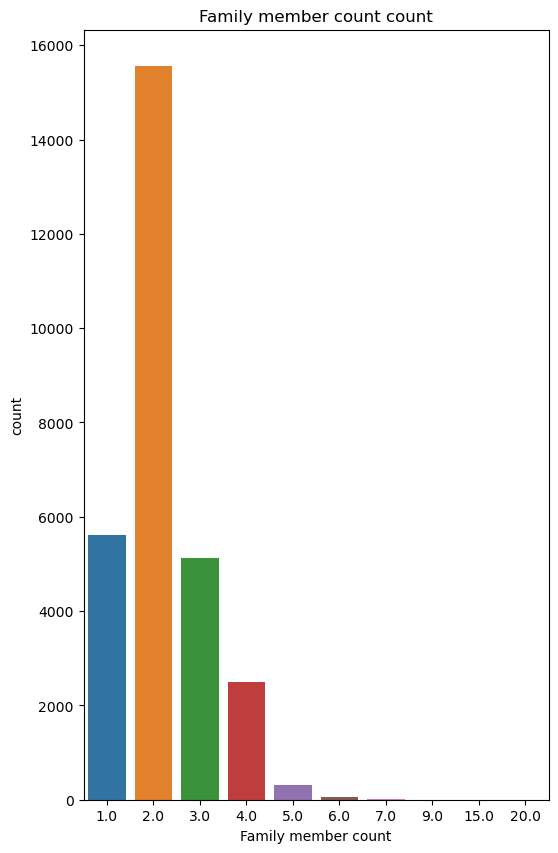

In [173]:
create_bar_plot(cc_train_copy, "Family member count")

- Majority of the applicants have a family member of 2 that means they dont have a child


Is high risk
0    2.198284
1    2.154309
Name: Family member count, dtype: float64


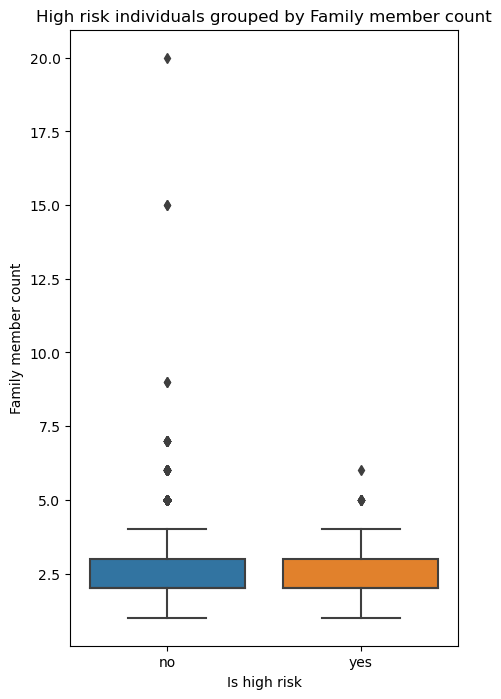

In [174]:
low_high_risk_box_plot(cc_train_copy, "Family member count")

<h1>Children Count</h1>

In [175]:
get_info_feat(cc_train_copy, "Children count")

Description:
count    29165.000000
mean         0.430790
std          0.741882
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         19.000000
Name: Children count, dtype: float64
__________________________________________________
Object type:
int64
__________________________________________________
Value count:
    Count  Frequency(%)
0   20143     69.065661
1    6003     20.582890
2    2624      8.997086
3     323      1.107492
4      52      0.178296
5      15      0.051432
7       2      0.006858
14      2      0.006858
19      1      0.003429


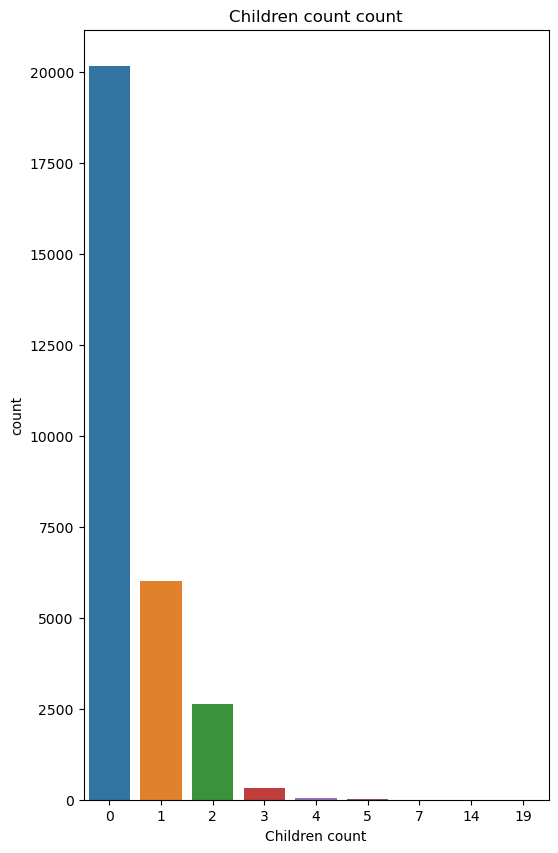

In [176]:
create_bar_plot(cc_train_copy, "Children count")

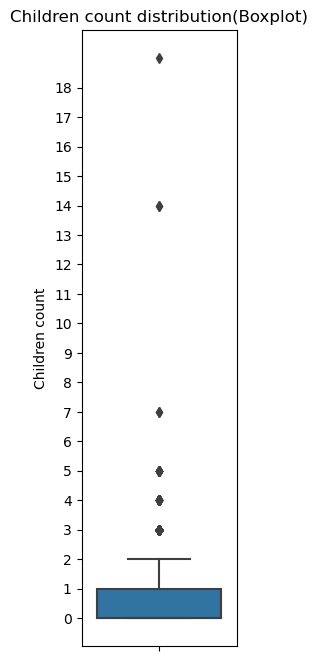

In [177]:
create_box_plot(cc_train_copy, "Children count")

As previously seen on family member count majority of the applicants dont have children 

<h1>Dwelling Type</h1>

In [178]:
get_info_feat(cc_train_copy, "Dwelling")

Description:
count                 29165
unique                    6
top       House / apartment
freq                  26059
Name: Dwelling, dtype: object
__________________________________________________
Object type:
object
__________________________________________________
Value count:
                     Count  Frequency(%)
House / apartment    26059     89.350249
With parents          1406      4.820847
Municipal apartment    912      3.127036
Rented apartment       453      1.553232
Office apartment       208      0.713184
Co-op apartment        127      0.435453


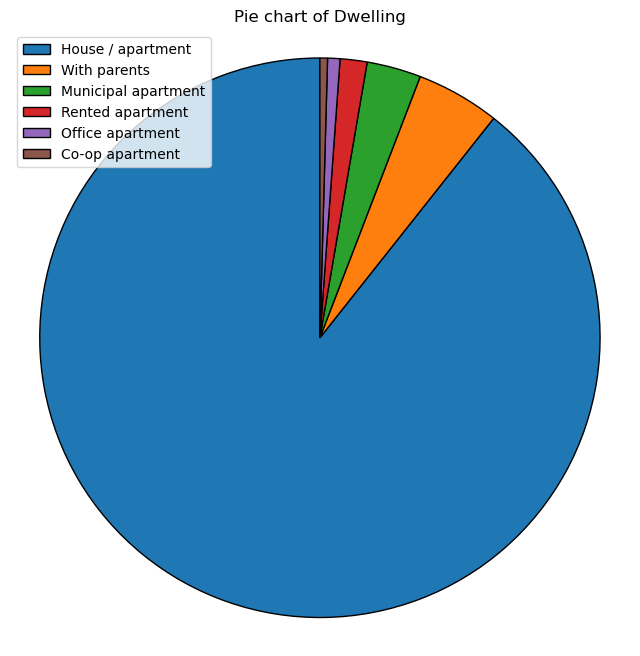

In [179]:
create_pie_plot(cc_train_copy, "Dwelling")

<function matplotlib.pyplot.show(close=None, block=None)>

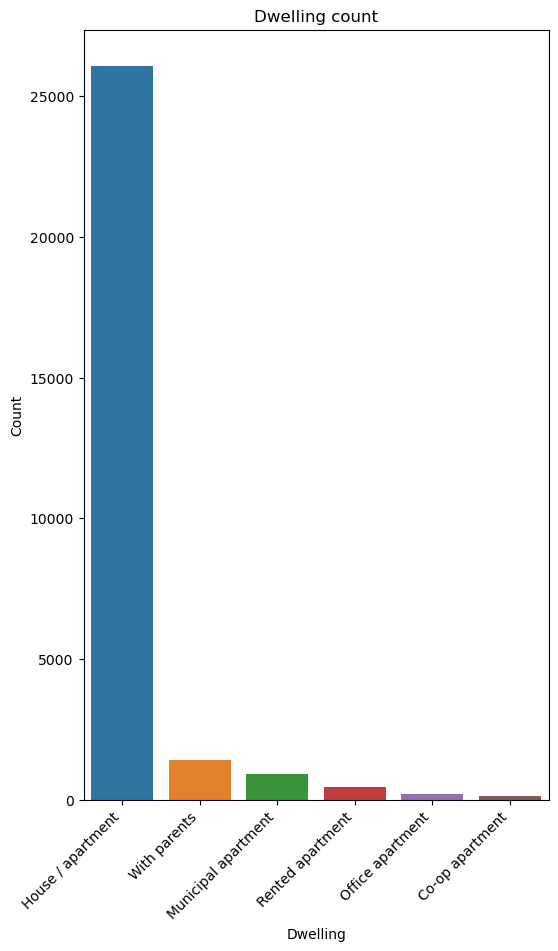

In [180]:
create_bar_plot(cc_train_copy,"Dwelling")

# Income

In [181]:
get_info_feat(cc_train_copy, "Income")

Description:
count    2.916500e+04
mean     1.868904e+05
std      1.014096e+05
min      2.700000e+04
25%      1.215000e+05
50%      1.575000e+05
75%      2.250000e+05
max      1.575000e+06
Name: Income, dtype: float64
__________________________________________________
Object type:
float64
__________________________________________________
Value count:
          Count  Frequency(%)
135000.0   3468     11.890965
180000.0   2487      8.527344
157500.0   2469      8.465627
225000.0   2373      8.136465
112500.0   2359      8.088462
...         ...           ...
164250.0      1      0.003429
42300.0       1      0.003429
432000.0      1      0.003429
145350.0      1      0.003429
82350.0       1      0.003429

[259 rows x 2 columns]


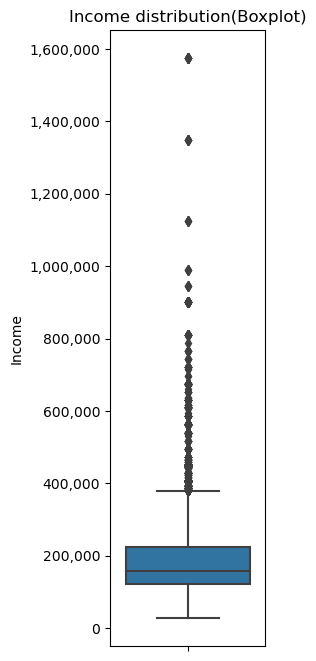

In [182]:
create_box_plot(cc_train_copy, "Income")

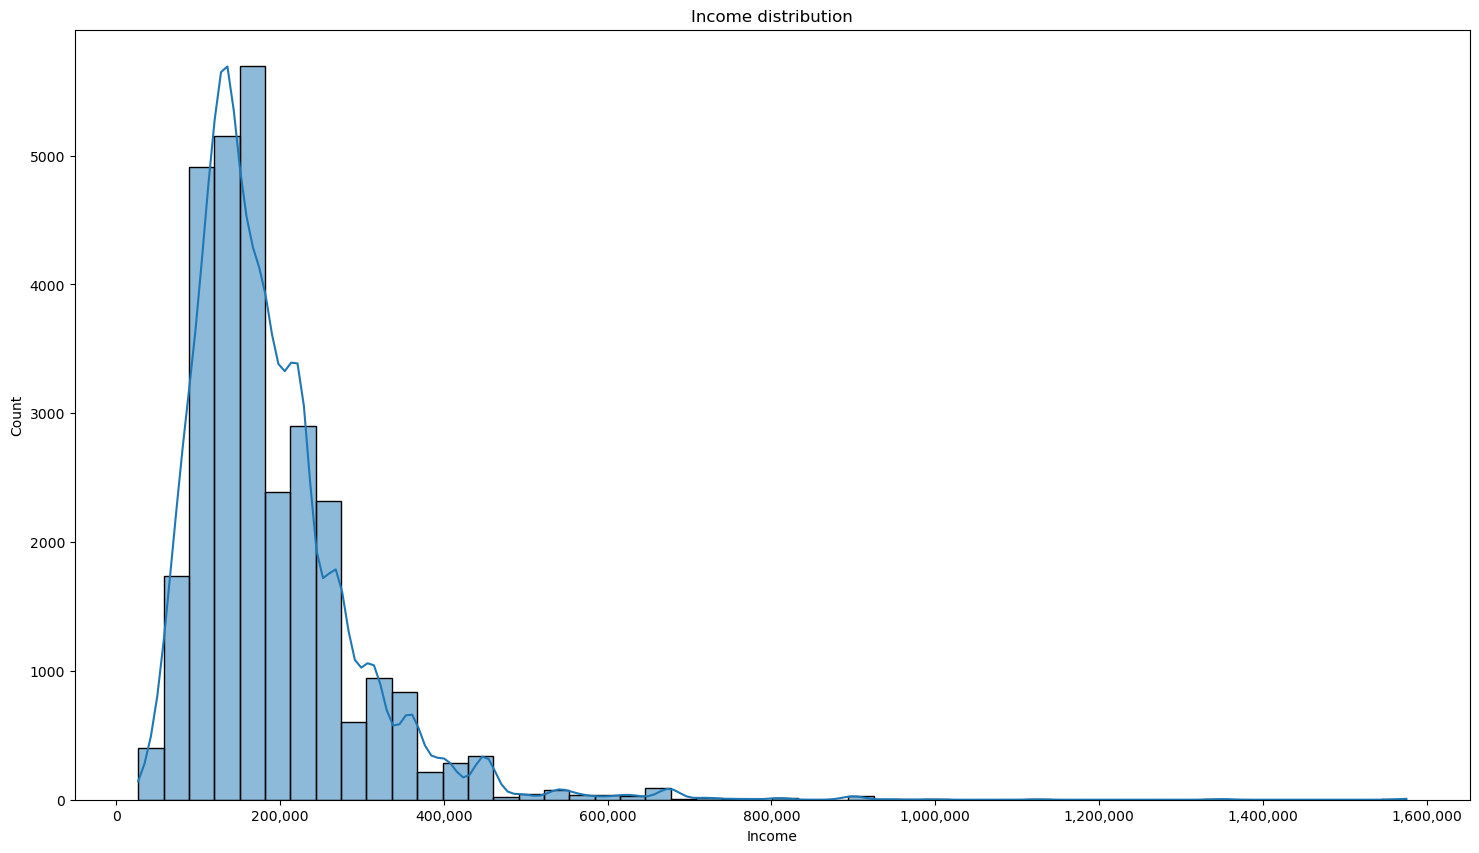

In [183]:
create_hist_plot(cc_train_copy, "Income")

Is high risk
0    186913.939650
1    185537.263527
Name: Income, dtype: float64


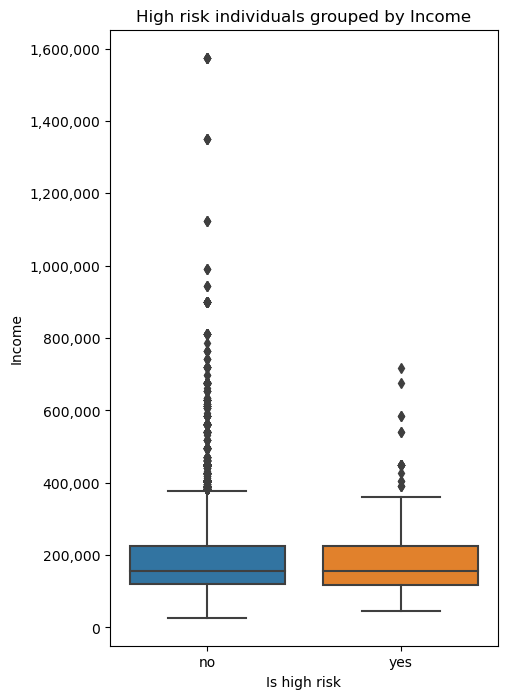

In [184]:
low_high_risk_box_plot(cc_train_copy, "Income")

# Job Title

In [185]:
get_info_feat(cc_train_copy, "Job title")

Description:
count        20138
unique          18
top       Laborers
freq          5004
Name: Job title, dtype: object
__________________________________________________
Object type:
object
__________________________________________________
Value count:
                       Count  Frequency(%)
Laborers                5004     24.848545
Core staff              2866     14.231801
Sales staff             2773     13.769987
Managers                2422     12.027014
Drivers                 1722      8.550998
High skill tech staff   1133      5.626179
Accountants              998      4.955805
Medicine staff           956      4.747244
Cooking staff            521      2.587149
Security staff           464      2.304102
Cleaning staff           425      2.110438
Private service staff    287      1.425166
Low-skill Laborers       138      0.685272
Waiters/barmen staff     127      0.630649
Secretaries              122      0.605820
HR staff                  72      0.357533
Realty agents 

In [186]:
print(f"Total row: {cc_train_copy.shape[0]}")
print(f"Missing rows: {cc_train_copy['Job title'].isna().sum()}")
print("The percentage of missing rows is {:.2f} %" .format( (cc_train_copy['Job title'].isna().sum())*100 /(cc_train_copy.shape[0])) )

Total row: 29165
Missing rows: 9027
The percentage of missing rows is 30.95 %


<function matplotlib.pyplot.show(close=None, block=None)>

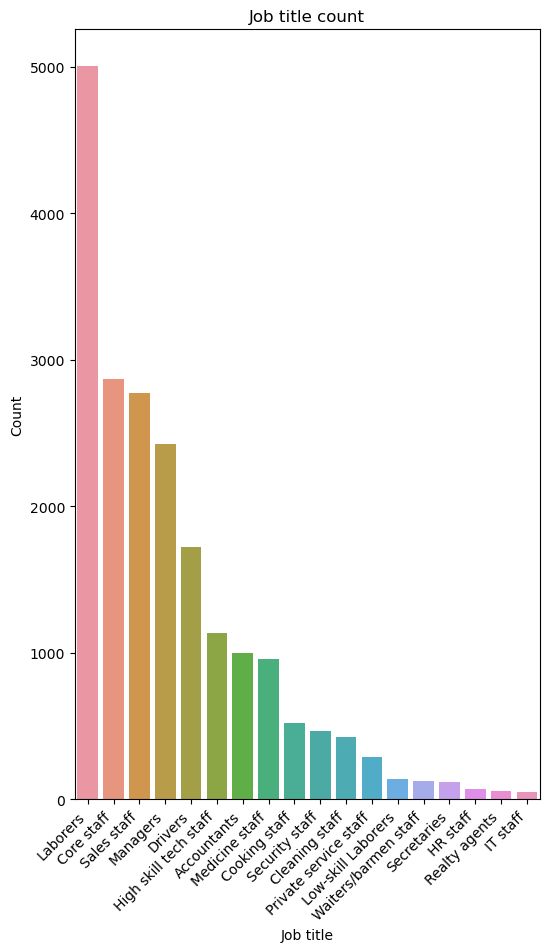

In [187]:
create_bar_plot(cc_train_copy, 'Job title')

# Employment Status

In [188]:
get_info_feat(cc_train_copy, 'Employment status')

Description:
count       29165
unique          5
top       Working
freq        15056
Name: Employment status, dtype: object
__________________________________________________
Object type:
object
__________________________________________________
Value count:
                      Count  Frequency(%)
Working               15056     51.623521
Commercial associate   6801     23.319047
Pensioner              4920     16.869535
State servant          2381      8.163895
Student                   7      0.024001


<function matplotlib.pyplot.show(close=None, block=None)>

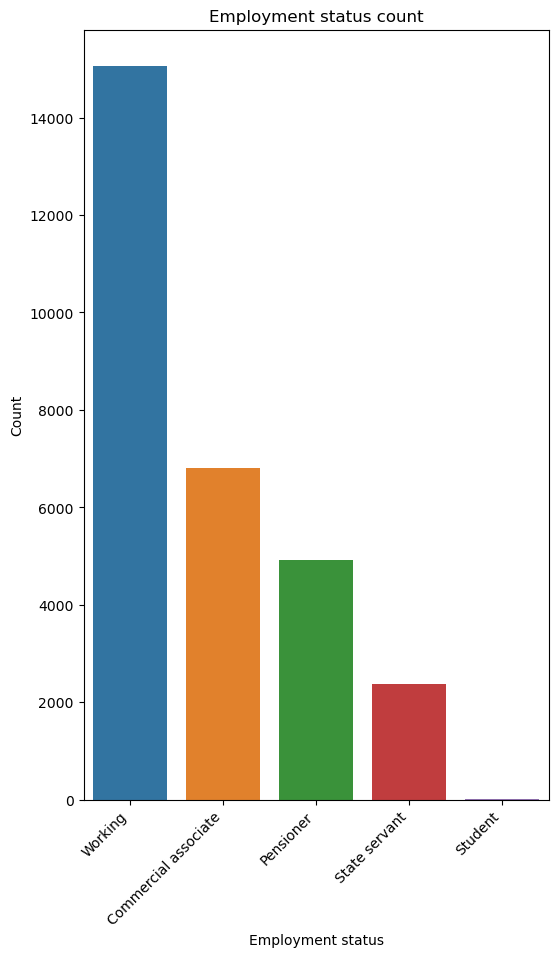

In [189]:
create_bar_plot(cc_train_copy, "Employment status")

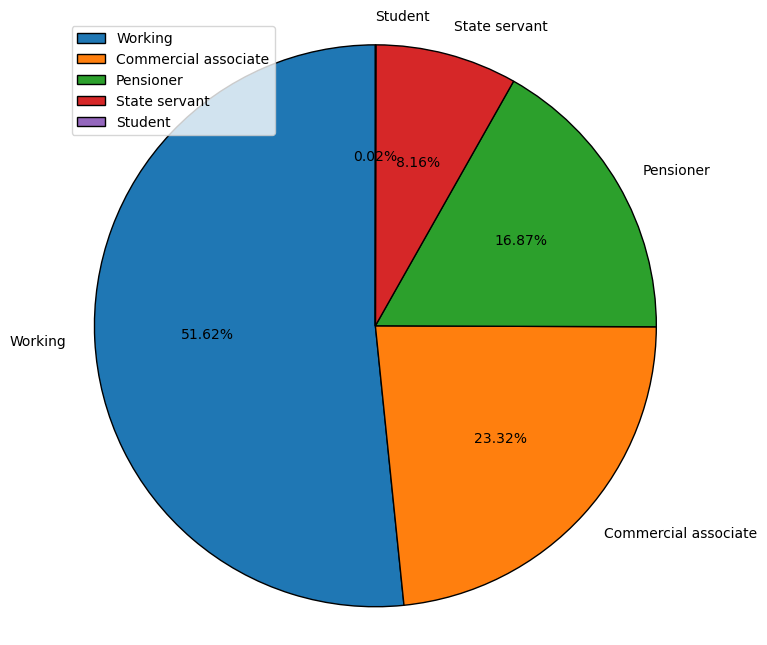

In [190]:
create_pie_plot(cc_train_copy, "Employment status")

# Education Level

In [191]:
get_info_feat(cc_train_copy,"Education level" )

Description:
count                             29165
unique                                5
top       Secondary / secondary special
freq                              19803
Name: Education level, dtype: object
__________________________________________________
Object type:
object
__________________________________________________
Value count:
                               Count  Frequency(%)
Secondary / secondary special  19803     67.899880
Higher education                7910     27.121550
Incomplete higher               1129      3.871078
Lower secondary                  298      1.021773
Academic degree                   25      0.085719


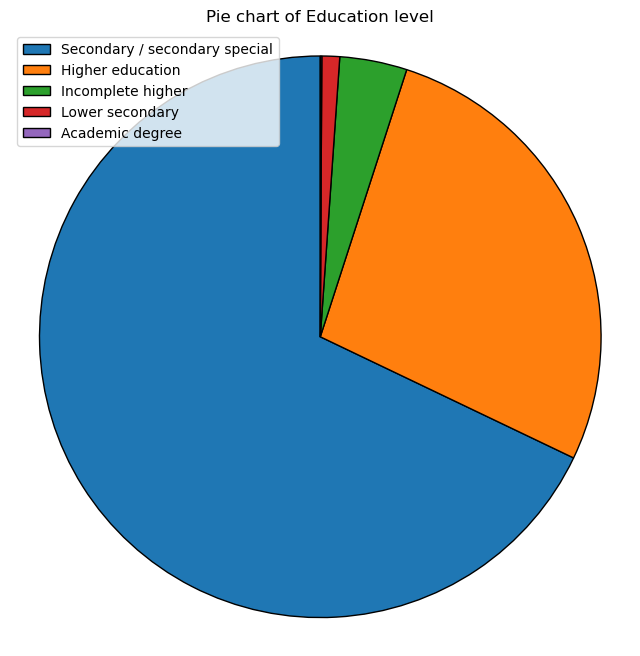

In [192]:
create_pie_plot(cc_train_copy, "Education level")

<function matplotlib.pyplot.show(close=None, block=None)>

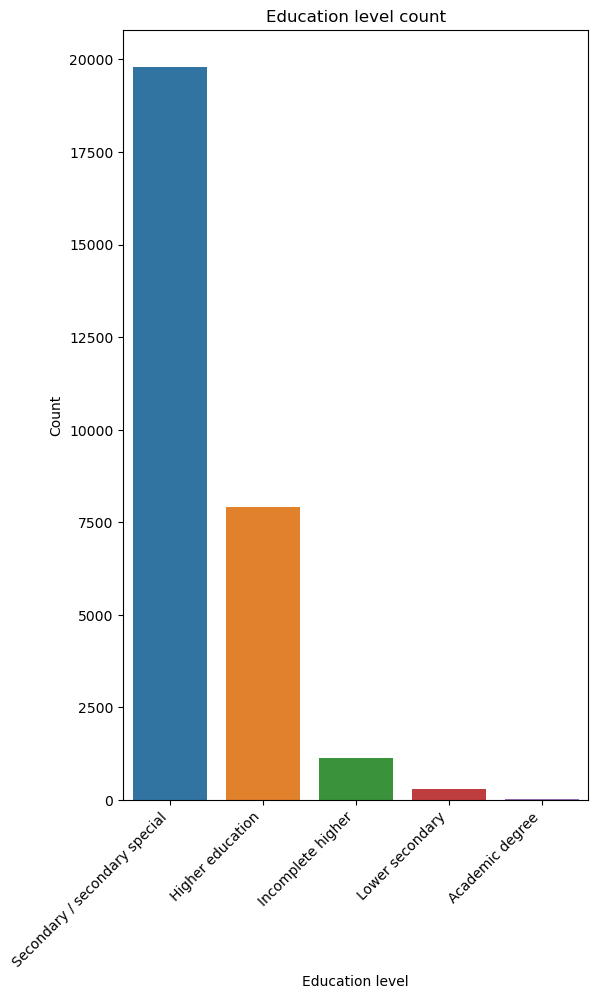

In [193]:
create_bar_plot(cc_train_copy, "Education level")

# Has a phone

In [194]:
get_info_feat(cc_train_copy, "Has a phone")

Description:
count    29165.000000
mean         0.294977
std          0.456040
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: Has a phone, dtype: float64
__________________________________________________
Object type:
int64
__________________________________________________
Value count:
   Count  Frequency(%)
0  20562     70.502314
1   8603     29.497686


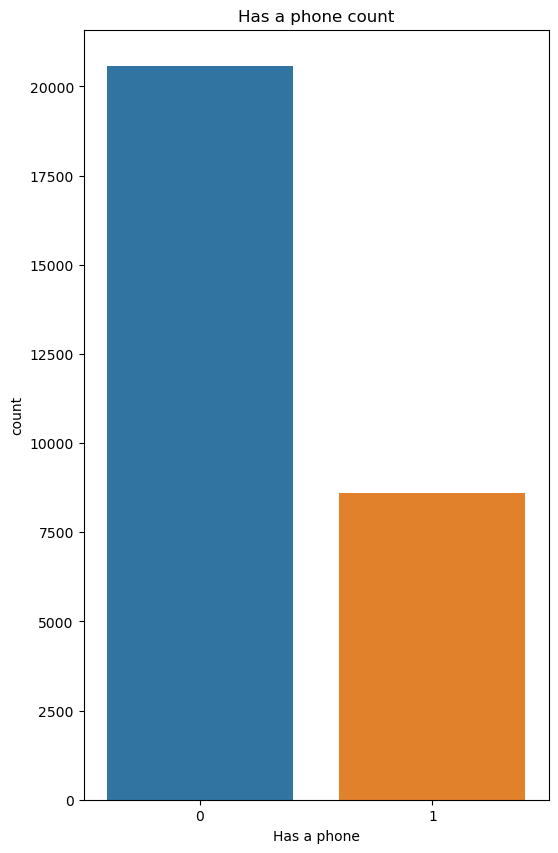

In [195]:
create_bar_plot(cc_train_copy, "Has a phone")

Surprisingly, most applicants does not have a phone.

# Has an email


In [196]:
get_info_feat(cc_train_copy, "Has an email")

Description:
count    29165.000000
mean         0.090279
std          0.286587
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Has an email, dtype: float64
__________________________________________________
Object type:
int64
__________________________________________________
Value count:
   Count  Frequency(%)
0  26532     90.972056
1   2633      9.027944


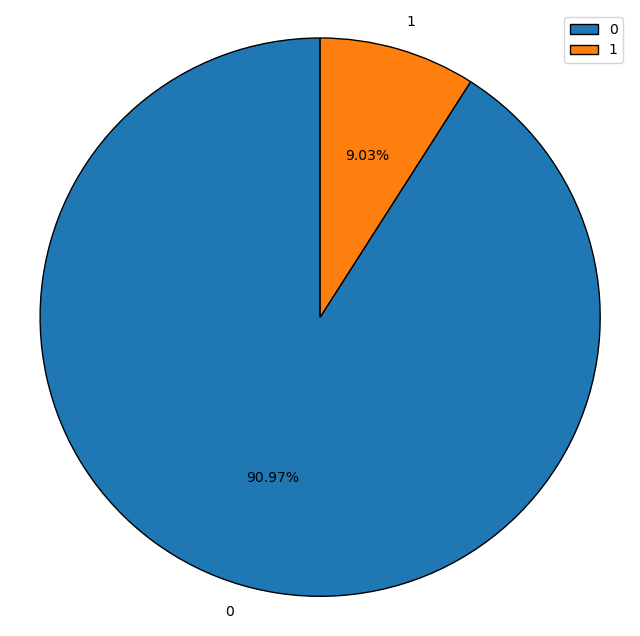

In [197]:
create_pie_plot(cc_train_copy, "Has an email")

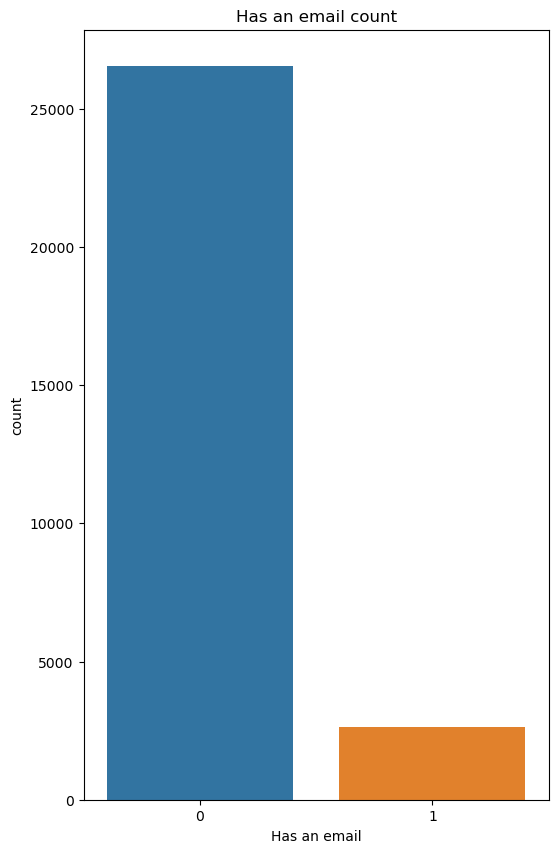

In [198]:
create_bar_plot(cc_train_copy, "Has an email")

Unbelievable !! More than 90% of applicant don't have an email

# Account Age

In [199]:
get_info_feat(cc_train_copy, "Account age")

Description:
count    29165.000000
mean        26.137734
std         16.486702
min          0.000000
25%         12.000000
50%         24.000000
75%         39.000000
max         60.000000
Name: Account age, dtype: float64
__________________________________________________
Object type:int64


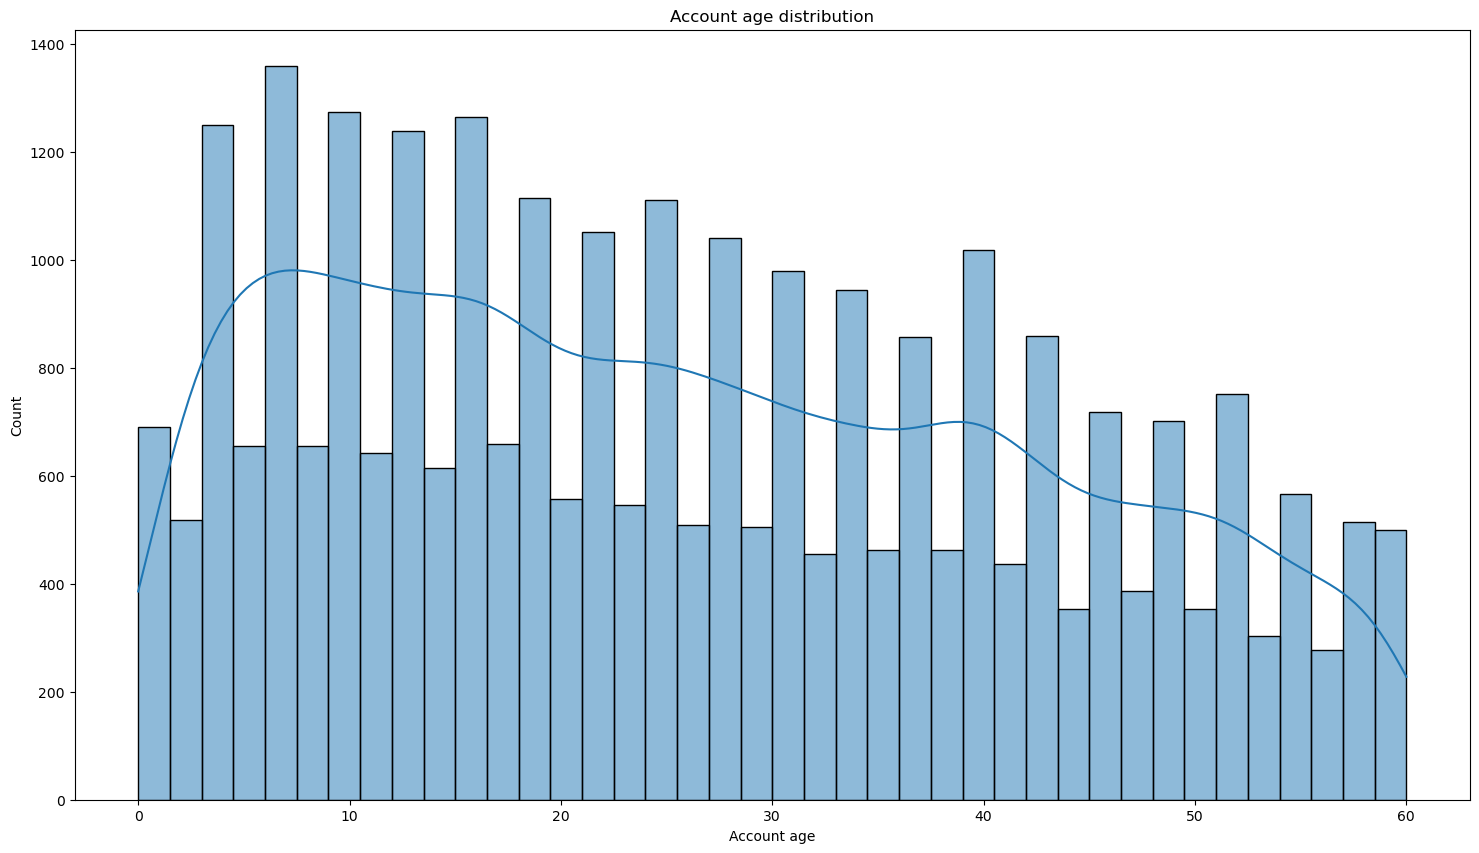

In [200]:
create_hist_plot(cc_train_copy, "Account age", the_bins= 40)

Is high risk
0    26.000105
1    34.044088
Name: Account age, dtype: float64


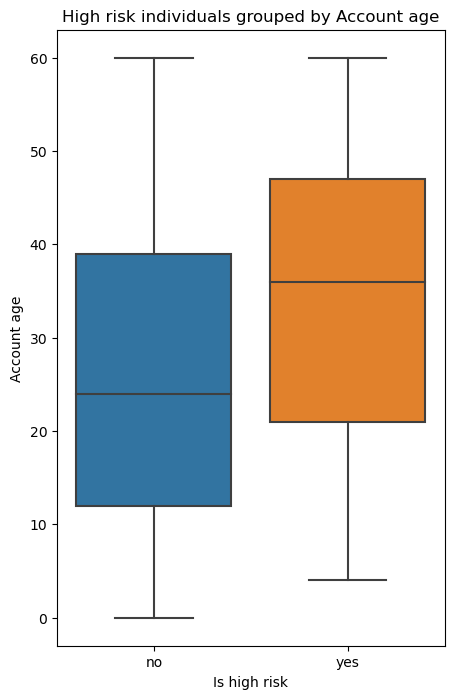

In [201]:
low_high_risk_box_plot(cc_train_copy, "Account age")

# Is high risk

In [202]:
get_info_feat(cc_train_copy, "Is high risk")

Description:
count     29165
unique        2
top           0
freq      28666
Name: Is high risk, dtype: int64
__________________________________________________
Object type:
object
__________________________________________________
Value count:
   Count  Frequency(%)
0  28666     98.289045
1    499      1.710955


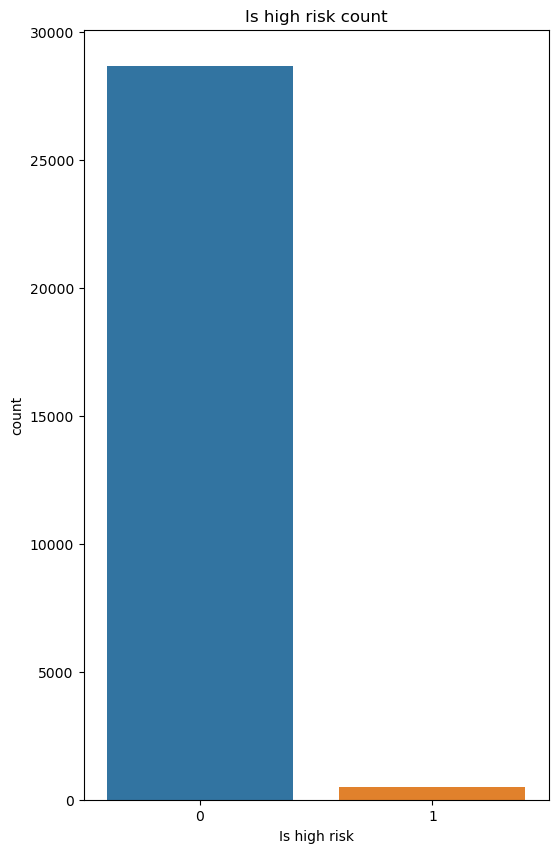

In [203]:
create_bar_plot(cc_train_copy, "Is high risk")

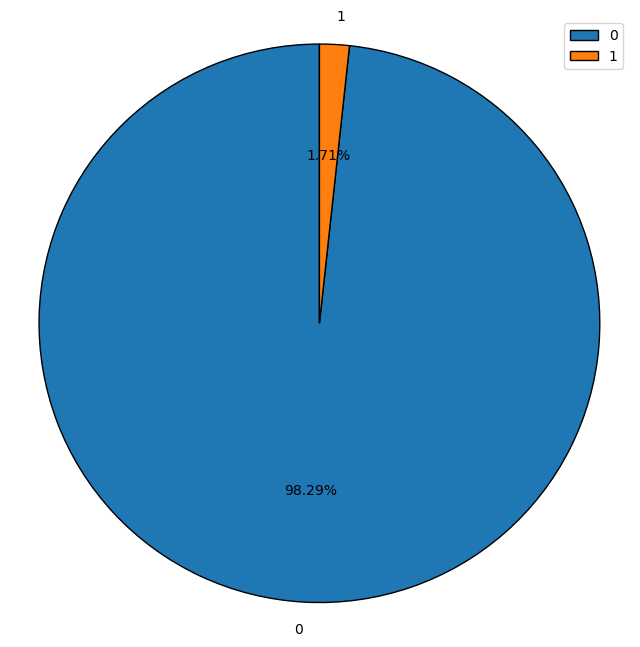

In [204]:
create_pie_plot(cc_train_copy,"Is high risk")


Vast majority are low risk applicants <br>
0: No<br>
1: Yes

# Bivariate analysis

## Numerical vs numerical features(Correlation and scatter plots)

### scatter plots

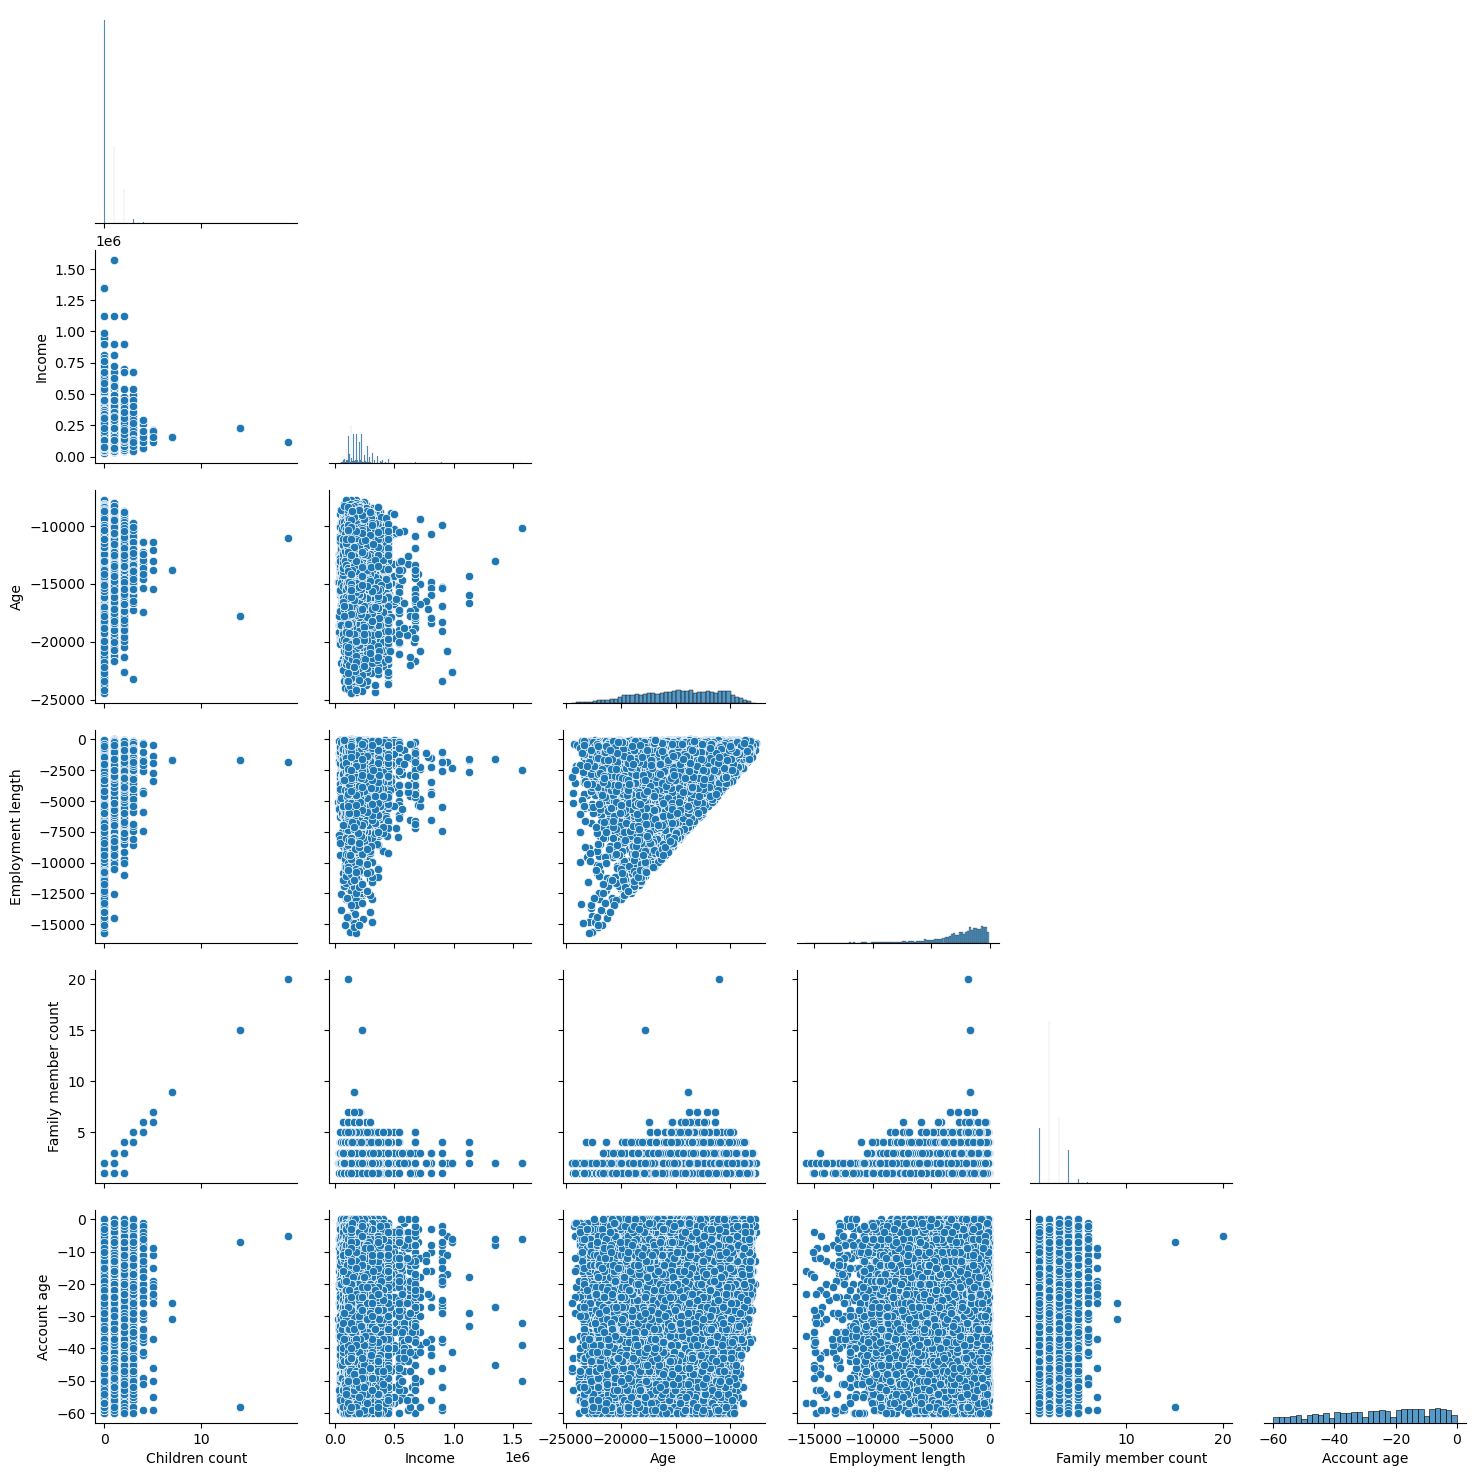

In [205]:
sns.pairplot(cc_train_copy[cc_train_copy['Employment length']<0].drop(['ID', 'Has a phone', "Has a work phone", 'Has a mobile phone','Has an email', "Is high risk"]
                                                                      , axis=1),
             corner= True
            )
plt.show()

Interpretation:
- A positive correlation between the number of family members and the number of children means that as the number of children increases, the number of family members also increases
- Similarly, a positive correlation between the age and employment length means that as age increases, the length of employment is expected to inceease as well. 

<AxesSubplot:xlabel='Children count', ylabel='Family member count'>

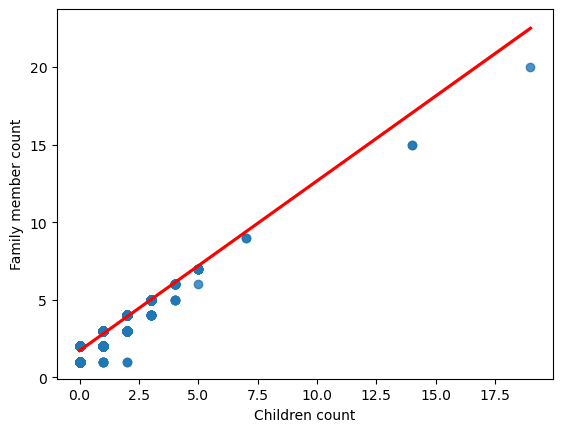

In [206]:
sns.regplot(x= 'Children count', y= 'Family member count', data= cc_train_copy, line_kws= {'color': 'red'})

In this case, it is stated that the number of family members is directly proportional to the number of children. This means that as the number of children increases, the number of family members is expected to increase as well.



### Account age vs age 

/Users/arunaacharya/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


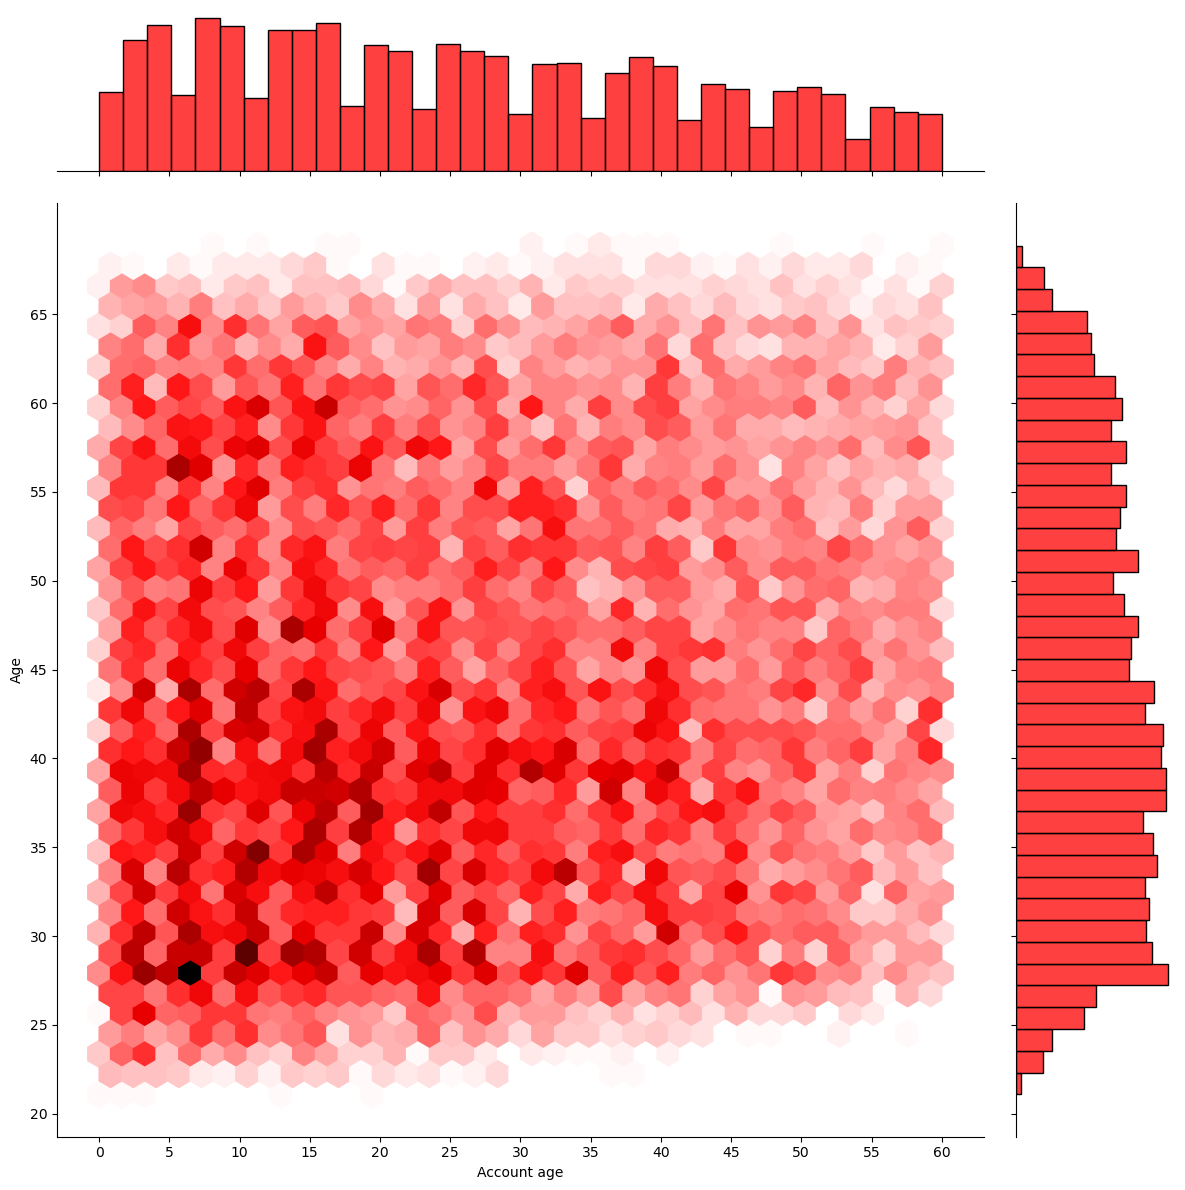

In [207]:
y_age= np.abs(cc_train_copy['Age'])/365.25
sns.jointplot(np.abs(cc_train_copy['Account age']), y_age, kind= 'hex', color='red',height= 12)
plt.yticks(np.arange(20, y_age.max(),5))
plt.xticks(np.arange(0,65,5))
plt.ylabel('Age')
plt.show()

- Majority of the applicants are age between 25 to 45 and their account is less thatn 25 months old

### Employment length vs age

/Users/arunaacharya/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


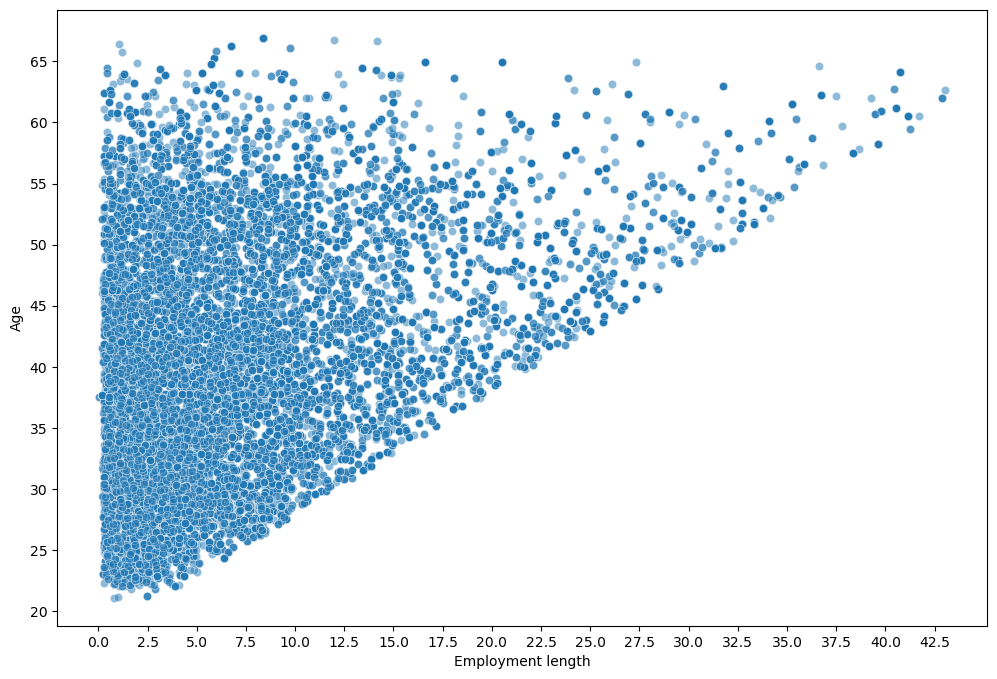

In [208]:
x_employ_length= np.abs(cc_train_copy[cc_train_copy['Employment length']<0]['Employment length'])/365.25
fig, ax= plt.subplots(figsize= (12, 8))
sns.scatterplot(x_employ_length, y_age, alpha= 0.5)
plt.xticks(np.arange(0, x_employ_length.max(), 2.5))
plt.yticks(np.arange(20, y_age.max(), 5))
plt.show()

We can see the positive correlation between Age and Employment length. Applicants who are older has longer employment length 

# Correlation analysis

In [209]:
cc_train_copy.head()

ID Gender Has a car Has a property  Children count    Income  \
0  5037048      M         Y              Y               0  135000.0   
1  5044630      F         Y              N               1  135000.0   
2  5079079      F         N              Y               2  180000.0   
3  5112872      F         Y              Y               0  360000.0   
4  5105858      F         N              N               0  270000.0   

      Employment status                Education level        Marital status  \
0               Working  Secondary / secondary special               Married   
1  Commercial associate               Higher education  Single / not married   
2  Commercial associate  Secondary / secondary special               Married   
3  Commercial associate               Higher education  Single / not married   
4               Working  Secondary / secondary special             Separated   

            Dwelling    Age  Employment length  Has a mobile phone  \
0       With parents -16271              -3111                   1   
1  House / apartment -10130              -1651                   1   
2  House / apartment -12821              -5657                   1   
3  House / apartment -20929              -2046                   1   
4  House / apartment -16207               -515                   1   

   Has a work phone  Has a phone  Has an email    Job title  \
0                 0            0             0   Core staff   
1                 0            0             0  Accountants   
2                 0            0             0     Laborers   
3                 0            0             1     Managers   
4                 0            1             0          NaN   

   Family member count Is high risk  Account age  
0                  2.0            0          -17  
1                  2.0            0           -1  
2                  4.0            0          -38  
3                  1.0            0          -11  
4                  1.0            0          -41

In [210]:
#change the data type of target feature to int
is_high_risk= cc_train_copy['Is high risk'].astype('int32')
is_high_risk.head()

0    0
1    0
2    0
3    0
4    0
Name: Is high risk, dtype: int32

(11, 11)


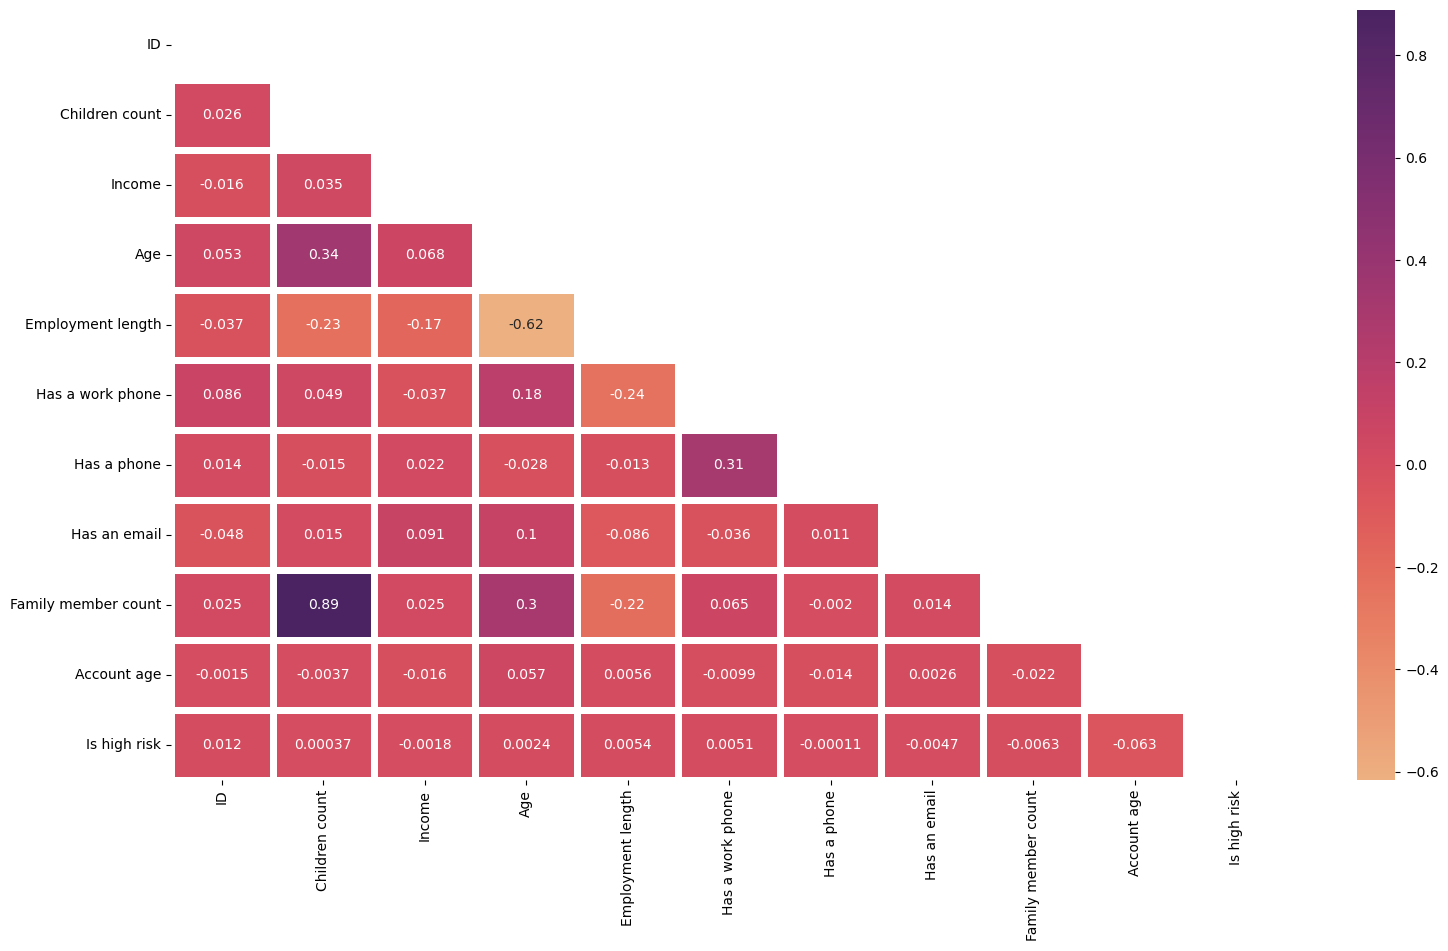

In [211]:
# correlation analysis with heatmap, after dropping the has a mobile phone with the target feature as int
cc_train_copy_corr_no_mobile= pd.concat([cc_train_copy.drop(['Has a mobile phone', 'Is high risk'], axis= 1,), is_high_risk], axis= 1).corr()
print(cc_train_copy_corr_no_mobile.shape)
# get the lower triangle of the correlation matrix
# generate a mask for the upper triangle
mask= np.zeros_like(cc_train_copy_corr_no_mobile, dtype='bool')
mask[np.triu_indices_from(mask)]= True
#setup the matplotlib figure
fig, ax= plt.subplots(figsize=(18,10))
#seaborn heatmap
sns.heatmap(cc_train_copy_corr_no_mobile, annot= True, cmap= "flare", mask= mask ,linewidths= 5)
plt.show()


Interpretation:
- No feature are correlated with the target feature: Is high risk
- As discussed before family member count is highly correlated with children count 
- Negative correlation between employment length and age 

# Numerical vs categorical features

### Age vs the rest of categorical features

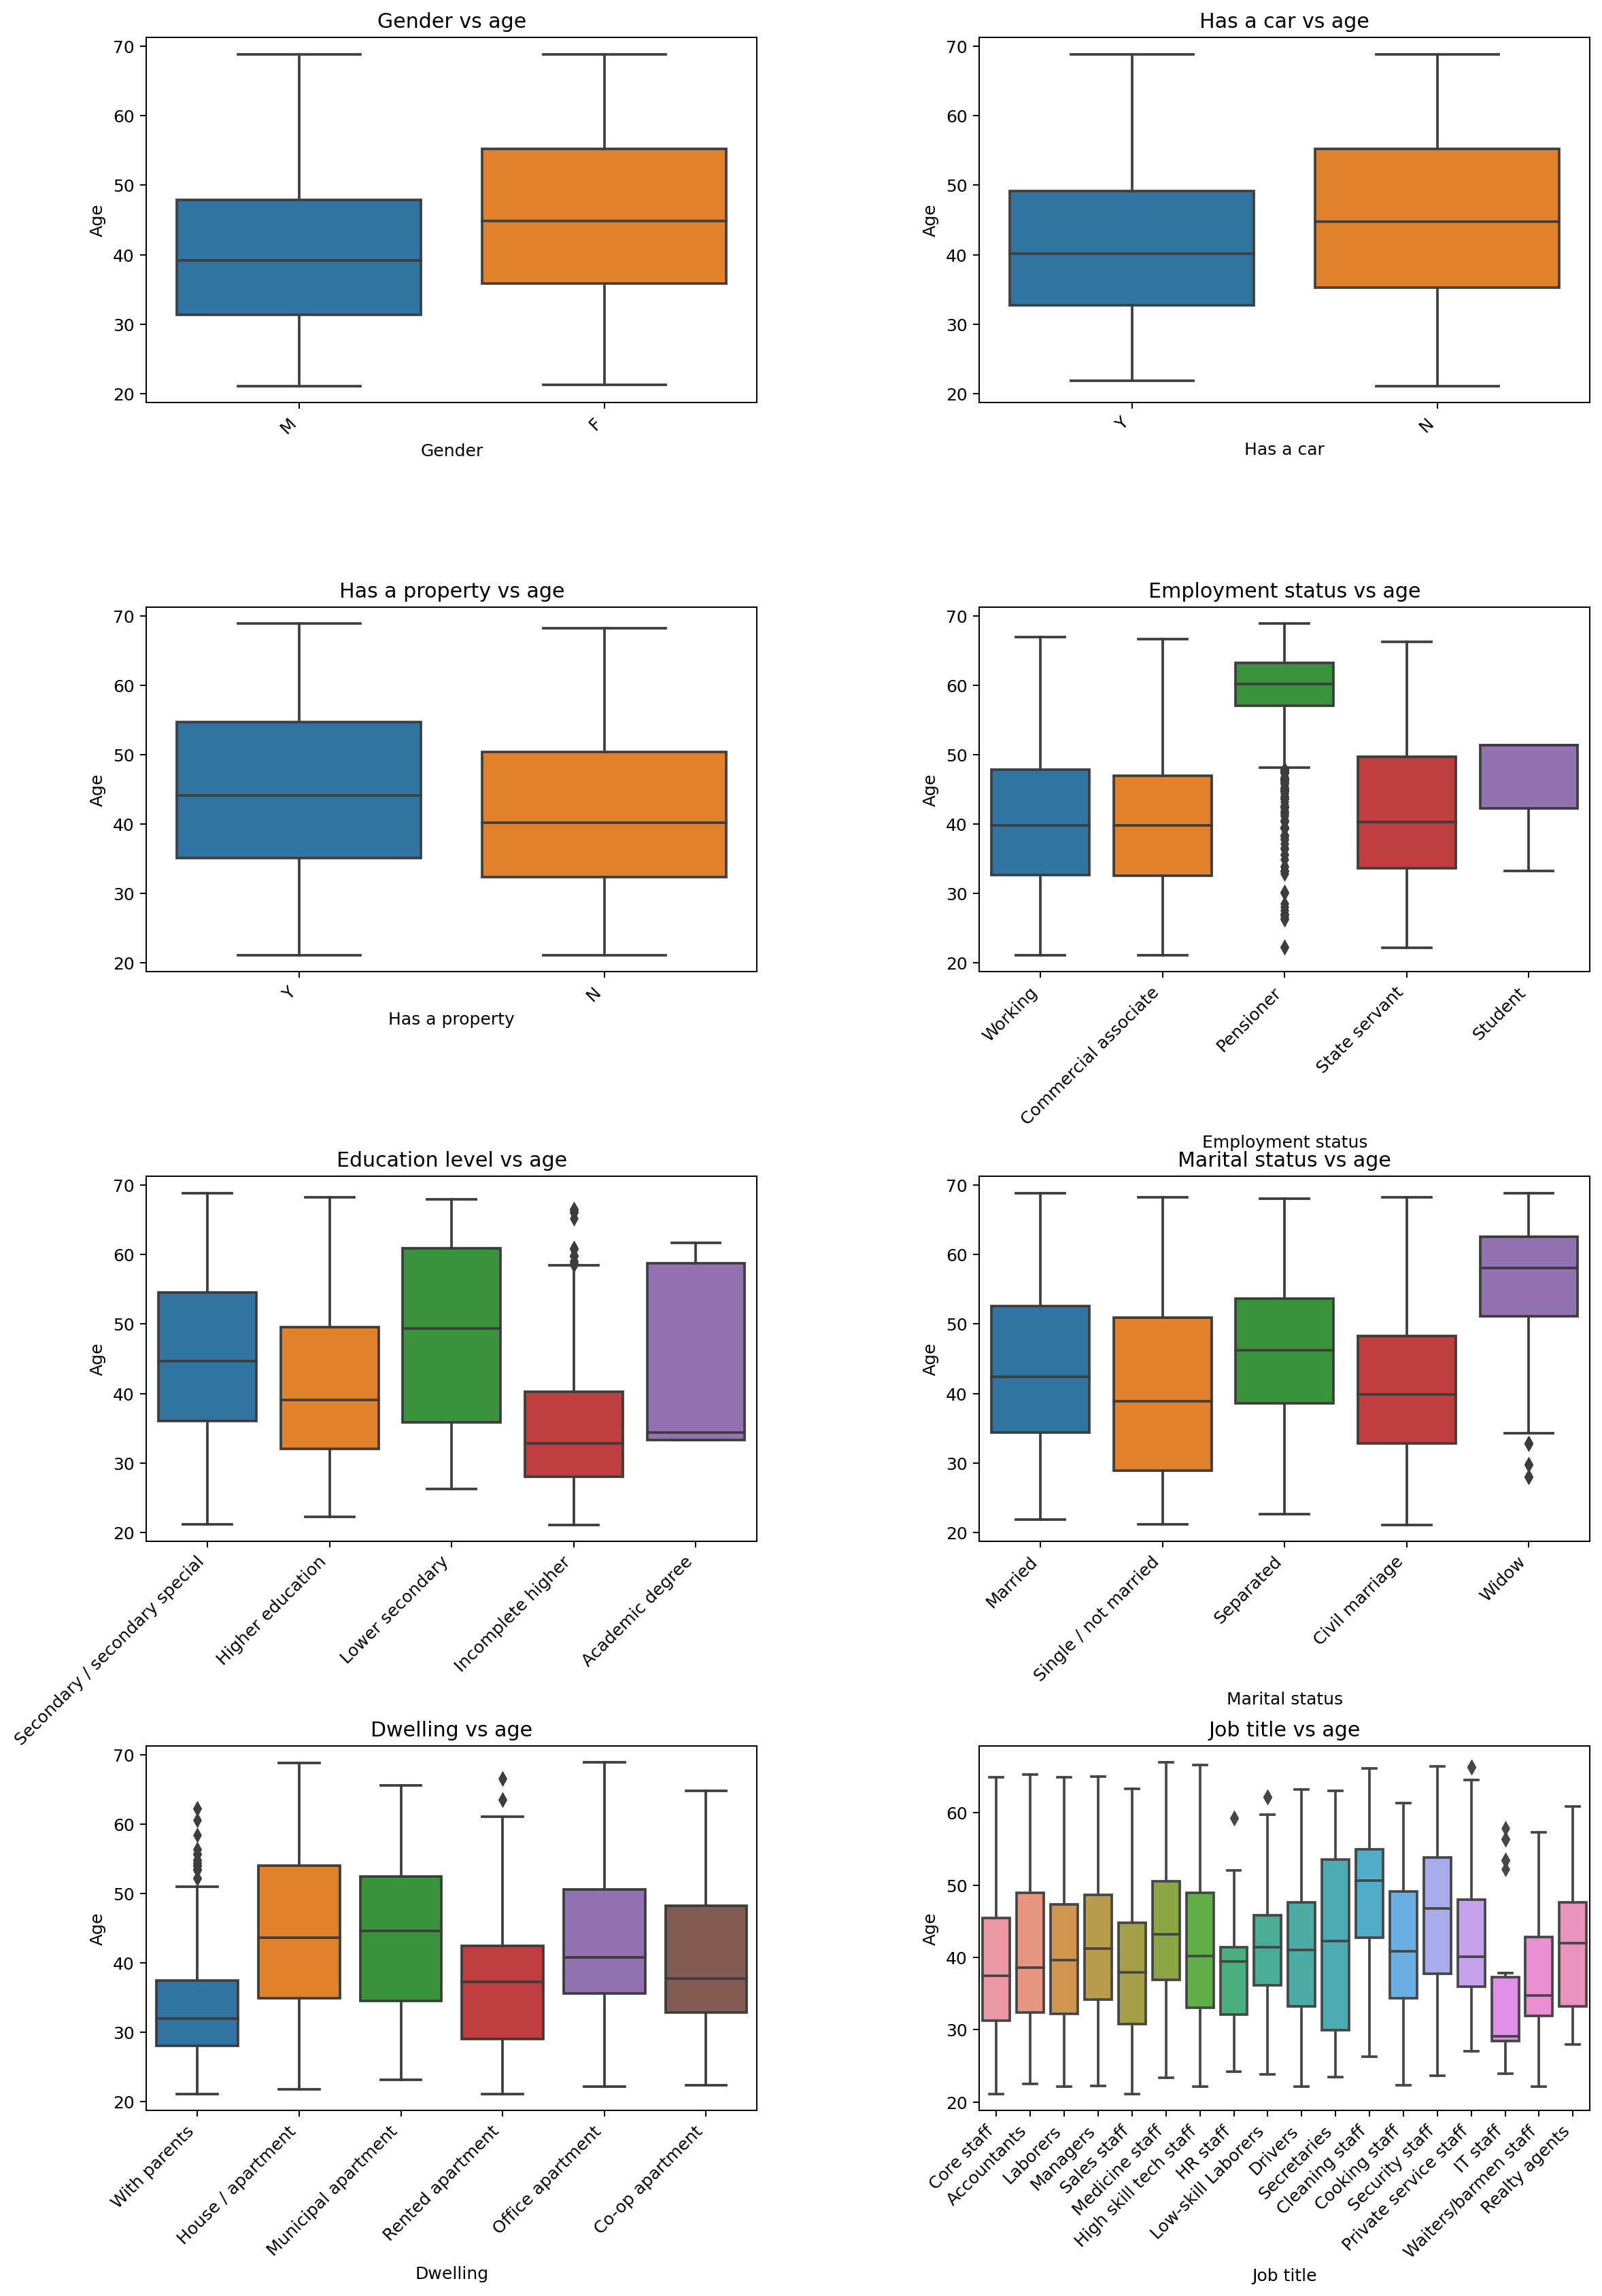

In [218]:
fig, axes = plt.subplots(4,2,figsize=(15,20),dpi=180)
fig.tight_layout(pad=10.0)
cat_features = ['Gender', 'Has a car', 'Has a property', 'Employment status', 'Education level', 'Marital status', 'Dwelling', 'Job title']
for cat_ft_count, ax in enumerate(axes):
    for row_count in range(4):
        for feat_count in range(2):
            sns.boxplot(ax=axes[row_count,feat_count]
                        ,x=cc_train_copy[cat_features[cat_ft_count]],
                        y=np.abs(cc_train_copy['Age'])/365.25)
            axes[row_count,feat_count].set_title(cat_features[cat_ft_count] + " vs age")
            plt.sca(axes[row_count,feat_count])
            plt.xticks(rotation=45,ha='right')
            plt.ylabel('Age')
            cat_ft_count += 1
    break

# Employment length vs the rest of categorical features

[[<AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:>]
 [<AxesSubplot:> <AxesSubplot:>]]


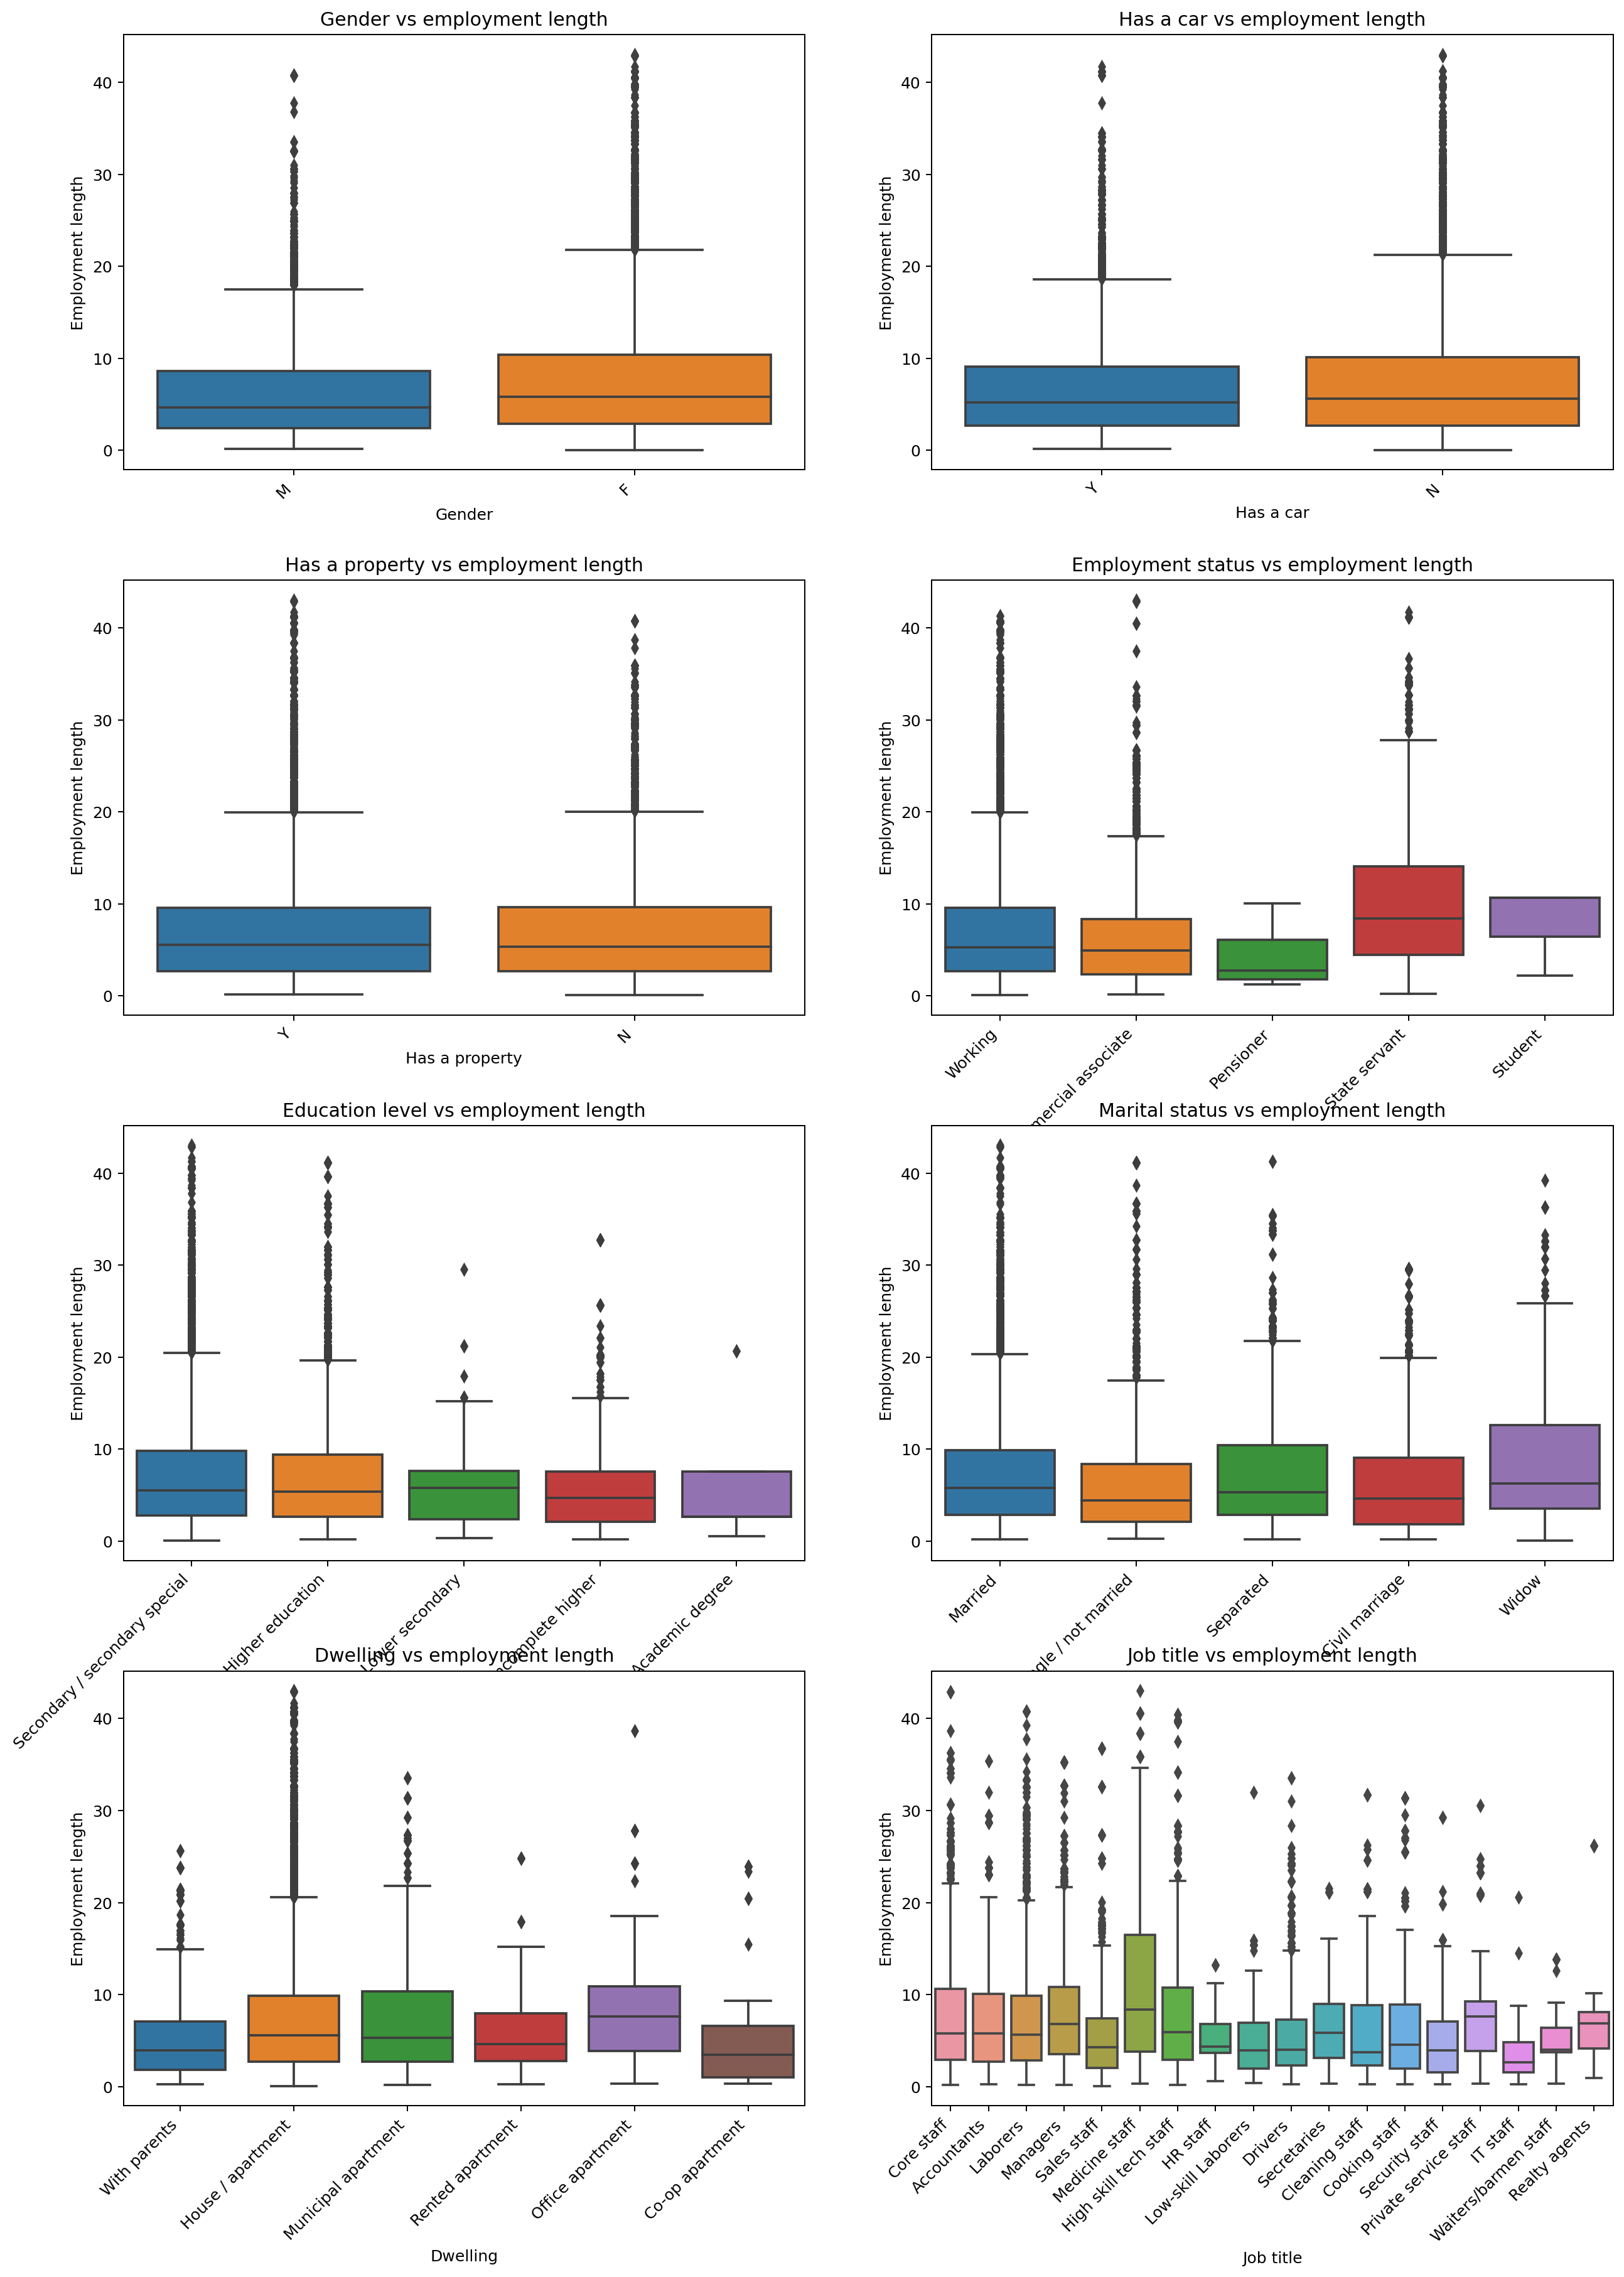

In [236]:
fig, axes= plt.subplots(4,2, figsize = (15,20), dpi= 180)
fig.tight_layout(pad= 5.0)
print(axes)
for cat_ft_count, ax in enumerate(axes):
    for row_count in range(4):
        for feat_count in range(2):            
            sns.boxplot(ax= axes[row_count, feat_count], 
                       x= cc_train_copy[cat_features[cat_ft_count]],
                       y= np.abs(cc_train_copy[cc_train_copy['Employment length']<0]['Employment length'])/365.25)
            axes[row_count, feat_count].set_title(cat_features[cat_ft_count]+" vs employment length")
            plt.sca(axes[row_count, feat_count])
            plt.ylabel('Employment length')
            plt.xticks(rotation= 45, ha='right')
            cat_ft_count +=1
    break

### Income vs other categorical features

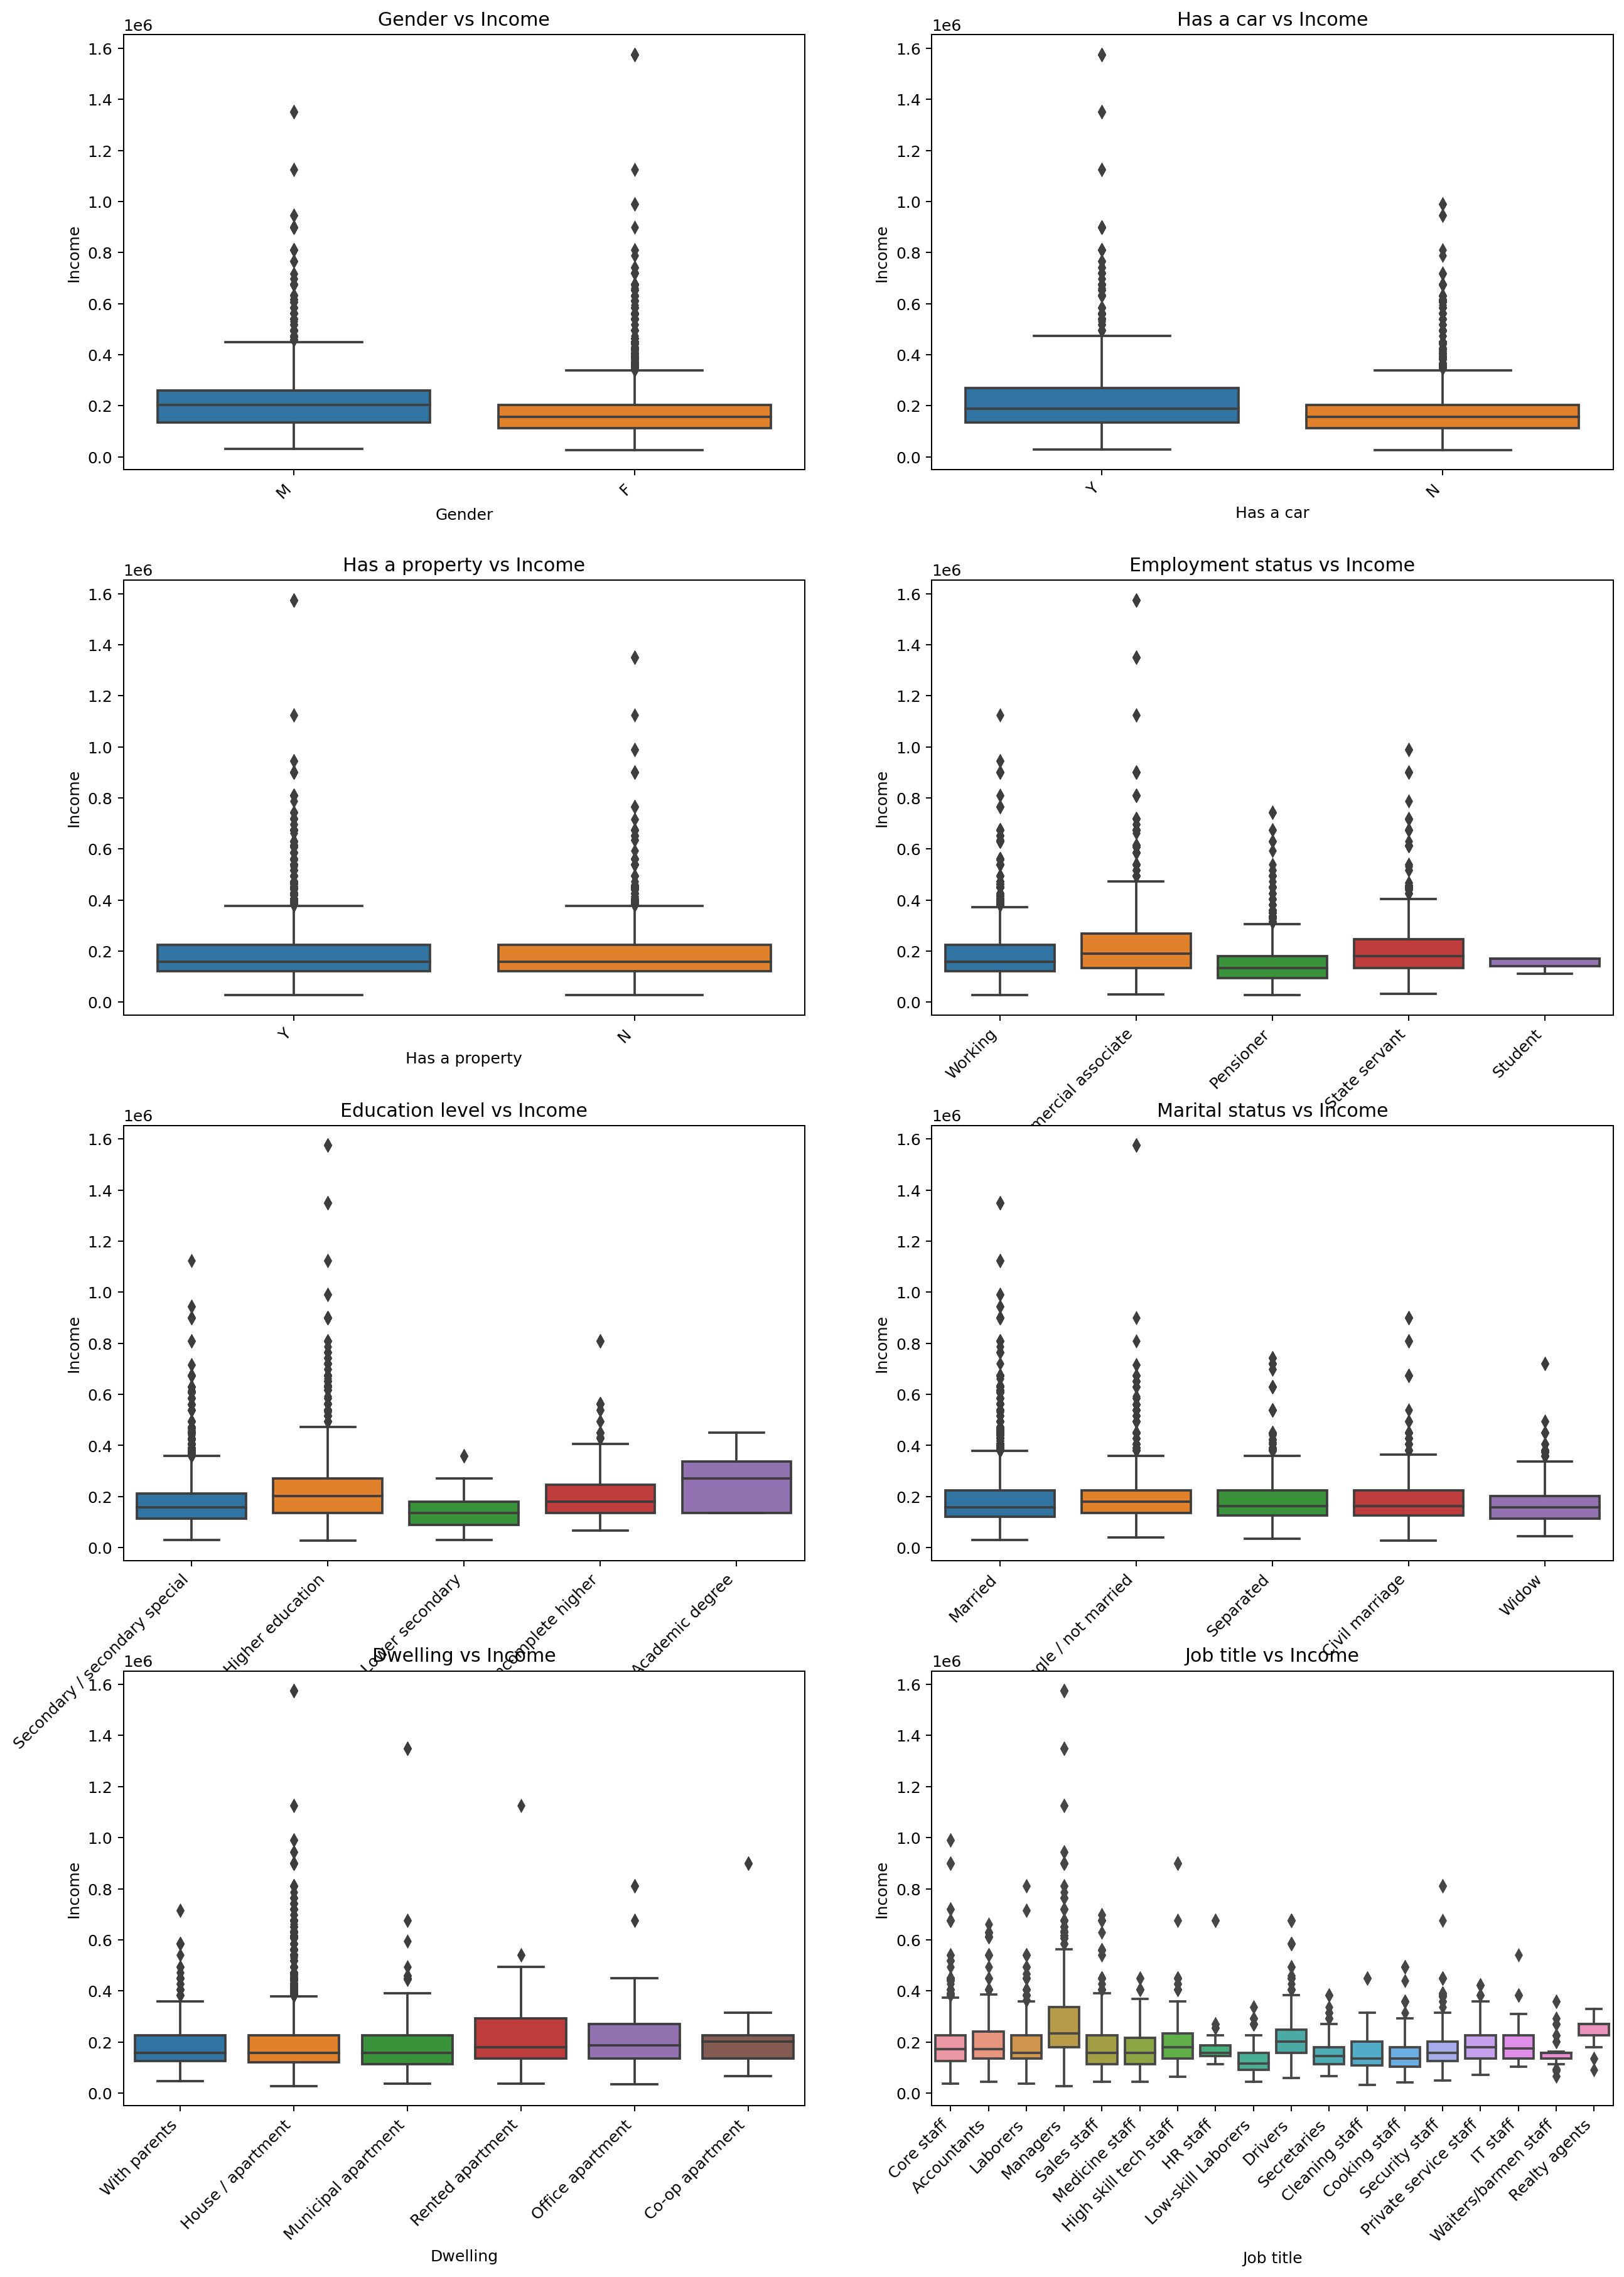

In [252]:
fig, axes= plt.subplots(4,2, figsize = (15,20), dpi= 180)
fig.tight_layout(pad= 5.0)

for cat_ft_count, ax in enumerate(axes):
    for row_count in range(4):
        for feat_count in range(2):            
            sns.boxplot(ax= axes[row_count, feat_count], 
                       x= cc_train_copy[cat_features[cat_ft_count]],
                       y= cc_train_copy['Income']
                       )                        
            axes[row_count, feat_count].set_title(cat_features[cat_ft_count]+" vs Income")
            plt.sca(axes[row_count, feat_count])
            plt.ylabel('Income')
            plt.xticks(rotation= 45, ha='right')
            cat_ft_count +=1
    break

# Categorical vs categorical features (Chi-square test)

In [318]:
def chi_func(feature):
    #selection row with high risk
    high_risk_ft= cc_train_copy[cc_train_copy['Is high risk']==1][feature]
    high_risk_ft_ct= pd.crosstab(index= high_risk_ft, columns= ['Count']).rename_axis(None, axis= 1)
    #drop the index feature name
    high_risk_ft_ct.index.name= None
    obs= high_risk_ft_ct
    print('Observed value: \n')
    print(obs)
    print('\n')
    #expected value
    print(obs.index)
    exp= pd.DataFrame([obs['Count'].sum()/len(obs)]*len(obs.index),columns= ['Count'],index= obs.index)
    print('Expected values: \n')
    print(exp)
    print('\n')
    chi_squared_stat= (((obs-exp)**2)/exp).sum()
    print('Chi-square: \n')
    print(chi_squared_stat[0])
    print('\n')
    #critical value
    crit= chi2.ppf(q= 0.95, df= len(obs)-1)
    print('Critical value: \n')
    print(crit)
    print('\n')
    p_value= 1- chi2.cdf(x= chi_squared_stat, df = len(obs)-1)
    print("P value : \n")
    print(p_value)
    print("\n")
    if chi_squared_stat[0]>= crit:
        print("Reject the null hypothesis")
    elif chi_squared_stat[0]<= crit:
        print("Fail to reject the null hypothesis")

In [317]:
chi_func("Dwelling")

Observed value: 

                     Count
Co-op apartment          2
House / apartment      437
Municipal apartment     24
Office apartment         6
Rented apartment         8
With parents            22


Index(['Co-op apartment', 'House / apartment', 'Municipal apartment',
       'Office apartment', 'Rented apartment', 'With parents'],
      dtype='object')
Expected values: 

                         Count
Co-op apartment      83.166667
House / apartment    83.166667
Municipal apartment  83.166667
Office apartment     83.166667
Rented apartment     83.166667
With parents         83.166667


Chi-square: 

1811.2164328657313


Critical value: 

11.070497693516351


P value : 

[0.]


Reject the null hypotheris


114      House / apartment
143    Municipal apartment
149      House / apartment
362      House / apartment
410    Municipal apartment
522      House / apartment
544       Office apartment
558      House / apartment
638      House / apartment
656      House / apartment
Name: Dwelling, dtype: object

In [319]:
cat_ft= ['Gender', 'Has a car', 'Has a property', 'Employment status', 'Education level', 'Marital status', 'Dwelling', 'Job title']
for ft in cat_ft:
    print('\n\n**********{}*******\n'.format(ft))
    chi_func(ft)



**********Gender*******

Observed value: 

   Count
F    306
M    193


Index(['F', 'M'], dtype='object')
Expected values: 

   Count
F  249.5
M  249.5


Chi-square: 

25.589178356713425


Critical value: 

3.841458820694124


P value : 

[4.22401699e-07]


Reject the null hypothesis


**********Has a car*******

Observed value: 

   Count
N    317
Y    182


Index(['N', 'Y'], dtype='object')
Expected values: 

   Count
N  249.5
Y  249.5


Chi-square: 

36.523046092184366


Critical value: 

3.841458820694124


P value : 

[1.50871859e-09]


Reject the null hypothesis


**********Has a property*******

Observed value: 

   Count
N    210
Y    289


Index(['N', 'Y'], dtype='object')
Expected values: 

   Count
N  249.5
Y  249.5


Chi-square: 

12.507014028056112


Critical value: 

3.841458820694124


P value : 

[0.00040543]


Reject the null hypothesis


**********Employment status*******

Observed value: 

                      Count
Commercial associate    114
Pensioner           